# Comparing EagleEye and various two-sample tests

> In this notebook we construct various trivial examples in which various methods trained to observe local denisty difference between two point clouds 
> fail to detect certain density morphologies, whislt EagleEye is still able to. 

In [1]:
#!/usr/bin/env python
"""
EagleEye vs. MLP-ratio two-sample test
-------------------------------------
Simulate a very concentrated anomaly in a subset of dimensions and
show when EagleEye still fires but the MLP fails because too few
signal points reach the network during training.
"""

import numpy as np
from scipy.stats import binom, norm
from sklearn.neighbors import NearestNeighbors
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# ------------------------------------------------------------
# EagleEye-style statistic (simplified)
# ------------------------------------------------------------
def eagleeye_test(X, Y,do_IDE=False,p_ext=1e-4):
    #%% EagleEye hyperparameters
    module_path = '../../eagleeye'
    import sys
    sys.path.append(module_path)
    import EagleEye
    from utils_EE import compute_the_null, partitioning_function
    p       = len(Y)/(len(Y)+len(X))
    
    K_M     = 200

    n_jobs  = 10

    #%% Eagle Soar!
    import importlib
    importlib.reload(EagleEye)
    import time

    stats_null                     = compute_the_null(p=p, K_M=K_M)
    t = time.time()
    result_dict, _       = EagleEye.Soar(X, Y, K_M=K_M, p_ext=p_ext, n_jobs=n_jobs, stats_null=stats_null, result_dict_in={},do_IDE=do_IDE)
    elapsed17alt = time.time() - t
    print(f'Elapsed time: {elapsed17alt} seconds')
    return stats_null,result_dict 


# ------------------------------------------------------------
# MLP classifier two-sample test
# ------------------------------------------------------------

# Make sure TF "sees" the Metal backend (for sanity check)

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
print("TF devices:", tf.config.list_physical_devices())

# ------------------------------------------------------------------
# sanity-check that a Metal-backed GPU is visible
# ------------------------------------------------------------------
gpus = tf.config.list_physical_devices("GPU")
if not gpus:
    raise RuntimeError("No GPU detected by TensorFlow — "
                       "verify tensorflow-metal installation.")
print("Using device:", gpus[0].name, "\n")

# OPTIONAL (usually not needed on Apple silicon, but harmless):
# tf.config.experimental.set_memory_growth(gpus[0], True)

# ------------------------------------------------------------------
# two-sample classifier in TF/Keras *on the GPU*
# ------------------------------------------------------------------

# ------------------------------------------------------------
#  After the model has been trained in mlp_c2st_tf(...)
# ------------------------------------------------------------
def extract_lr_scores(model, X_test, batch_size=1, from_logits=False):
    """
    Return per-point LR estimates and BCE loss values.

    Parameters
    ----------
    model        : trained tf.keras.Model
    X_test       : ndarray, shape (n_test, d)
    batch_size   : int
    from_logits  : bool, True if model's last layer has *linear* output
                   and we need to apply a sigmoid first
    Returns
    -------
    lr           : ndarray, LR estimate for every test point
    bce_loss_pt  : ndarray, point-wise binary-cross-entropy loss
    """
    # Predict class-1 probabilities
    y_hat = model.predict(X_test, batch_size=batch_size, verbose=0).ravel()
    if from_logits:                       # our mixed-precision path
        y_hat = tf.math.sigmoid(y_hat).numpy()

    # Likelihood-ratio estimate (priors were equal)
    lr = y_hat / (1.0 - y_hat + 1e-12)    # add ε to avoid /0

    # Point-wise binary-cross-entropy w.r.t. *true* label 1
    # (useful as a “surprise” score if you don't know the label)
    bce_loss_pt = -np.log(y_hat + 1e-12)

    return lr, bce_loss_pt


def mlp_c2st_tf_gpu(X_ref, X_data,data_labels ,
                    test_frac   = 0.3,
                    hidden      = (64, 64, 64),
                    epochs      = 30,
                    batch_size  = 128,
                    seed        = 42,
                    ):
                    
    
    """
    The data_lables are the SIGNAL labels. Not used in training - only parsed to get the validation split.
    MLP classifies x_ref vs x_data
    """


    tf.keras.utils.set_random_seed(seed)

    ref_labels = np.zeros(len(X_ref), dtype="float32")
    # build labelled dataset
    X = np.vstack([X_ref, X_data]).astype("float32")
    y = np.concatenate([np.zeros(len(X_ref),  dtype="float32"),
                        np.ones (len(X_data), dtype="float32")])
    labels = np.concatenate([np.zeros(len(X_ref), dtype="int"),data_labels]) # These are NOT used in training - these are the signal labels

    X_train, X_test, y_train, y_test, data_labels_train, data_labels_test = train_test_split(
        X, y, labels, test_size=test_frac, stratify=y, random_state=seed
    )

    # --------------------------------------------------------------
    # MODEL definition
    # --------------------------------------------------------------
    with tf.device("/GPU:0"):                            # <<< force GPU
        model = tf.keras.Sequential(
            [tf.keras.layers.Input(shape=(X.shape[1],))] +
            [tf.keras.layers.Dense(h, activation="relu") for h in hidden] +
            [tf.keras.layers.Dense(1, activation="sigmoid")]
        )

        model.compile(
            optimizer=tf.keras.optimizers.Adam(1e-3),
            loss="binary_crossentropy",
            metrics=[tf.keras.metrics.AUC(name="auc")]
        )

    # --------------------------------------------------------------
    # TRAIN  — still on the GPU because the model lives there
    # --------------------------------------------------------------
    es = tf.keras.callbacks.EarlyStopping(
        monitor="val_auc", mode="max",
        patience=3, restore_best_weights=True
    )

    model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[es],
        verbose=0          # set to 1 for a progress bar
    )

    # --------------------------------------------------------------
    # EVALUATE
    # --------------------------------------------------------------
    with tf.device("/GPU:0"):
        prob = model.predict(X_test, batch_size=batch_size, verbose=0).ravel()

    auc = roc_auc_score(y_test, prob)
    return auc,model,X_test,data_labels_test


TF devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using device: /physical_device:GPU:0 



# Needle in a haystack EagleEyE vs MLP



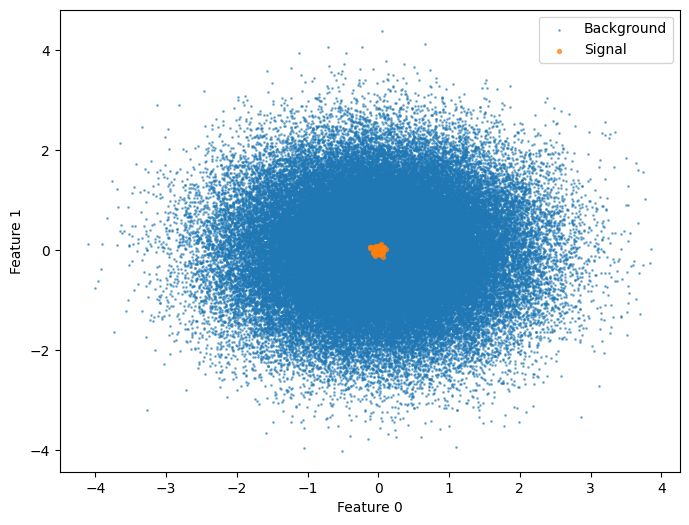

Number of background points: 100000
Number of signal points: 100


In [2]:
d      = 20
n_bg   = 200_000
n_sig  = 100         
sigma  = 0.05

X_bg   = np.random.randn(n_bg, d)
X_sig  = np.random.randn(n_sig, d) * sigma   # much tighter

# labels: 0 = background, 1 = signal 
X_data = np.vstack([X_bg[:len(X_bg)//2], X_sig])
signal_labels = np.hstack([np.zeros(len(X_bg)//2), np.ones(n_sig)])
X_ref  = X_bg[len(X_bg)//2:]


import matplotlib.pyplot as plt
# Plot the first two features, colored by label (background=0, signal=1)
plt.figure(figsize=(8, 6))
plt.scatter(X_data[signal_labels == 0, 0], X_data[signal_labels == 0, 1], s=1, alpha=0.5, label='Background')
plt.scatter(X_data[signal_labels == 1, 0], X_data[signal_labels == 1, 1], s=8, alpha=0.7, label='Signal')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.legend()
plt.savefig("/Users/andrescaffidi/Documents/Projects/EagleEye/examples/Basic_usage/MLP_comp_plots/haystack_data.png")
plt.show()
print(f"Number of background points: {n_bg//2}")
print(f"Number of signal points: {n_sig}")


## EagleEye

In [3]:
p_ext = 1e-5
eagleeye_test_result = eagleeye_test(X_ref, X_data,do_IDE=True,p_ext=p_ext)


-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
KNN completed: 5.00 %
KNN completed: 10.00 %
KNN completed: 14.99 %
KNN completed: 19.99 %
KNN completed: 24.99 %
KNN completed: 29.99 %
KNN completed: 34.98 %
KNN completed: 39.98 %
KNN completed: 44.98 %
KNN completed: 49.98 %
KNN completed: 54.97 %
KNN completed: 59.97 %
KNN completed: 64.97 %
KNN completed: 69.97 %
KNN completed: 74.96 %
KNN completed: 79.96 %
KNN completed: 84.96 %
KNN completed: 89.96 %
KNN completed: 94.95 %
KNN completed: 99.95 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Pruning via iterative density equalization (IDE)
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

Elapsed time: 45.81819796562195 seconds


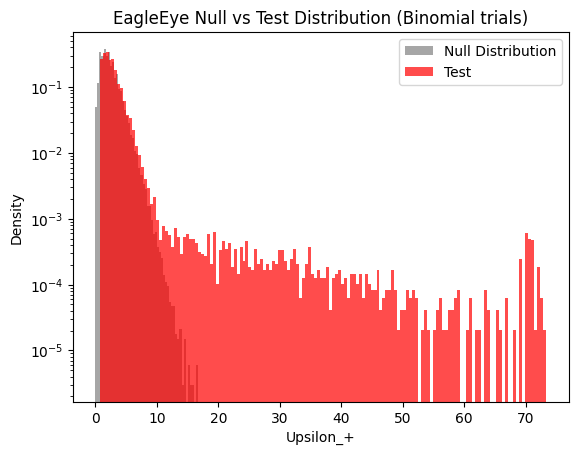

In [5]:
h = plt.hist(list(eagleeye_test_result[0].values())[0], bins=50, alpha=0.7, label='Null Distribution', color='grey', density=True)
h = plt.hist(eagleeye_test_result[1]['Upsilon_i_Y'], bins=150, alpha=0.7, label='Test', color='red', density=True)
plt.yscale('log')
plt.xlabel('Upsilon_+')
plt.ylabel('Density')
plt.title('EagleEye Null vs Test Distribution (Binomial trials)')
plt.legend()
plt.savefig("./MLP_comp_plots/eagleeye_null_vs_test_hist.png")
plt.show()

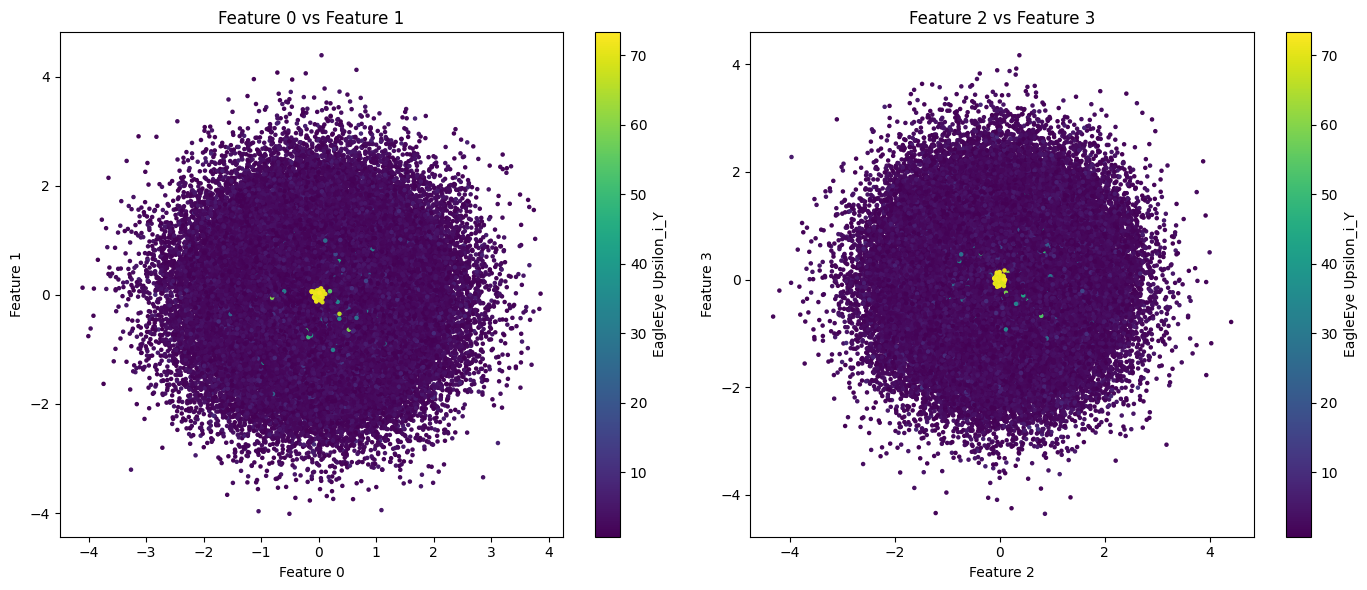

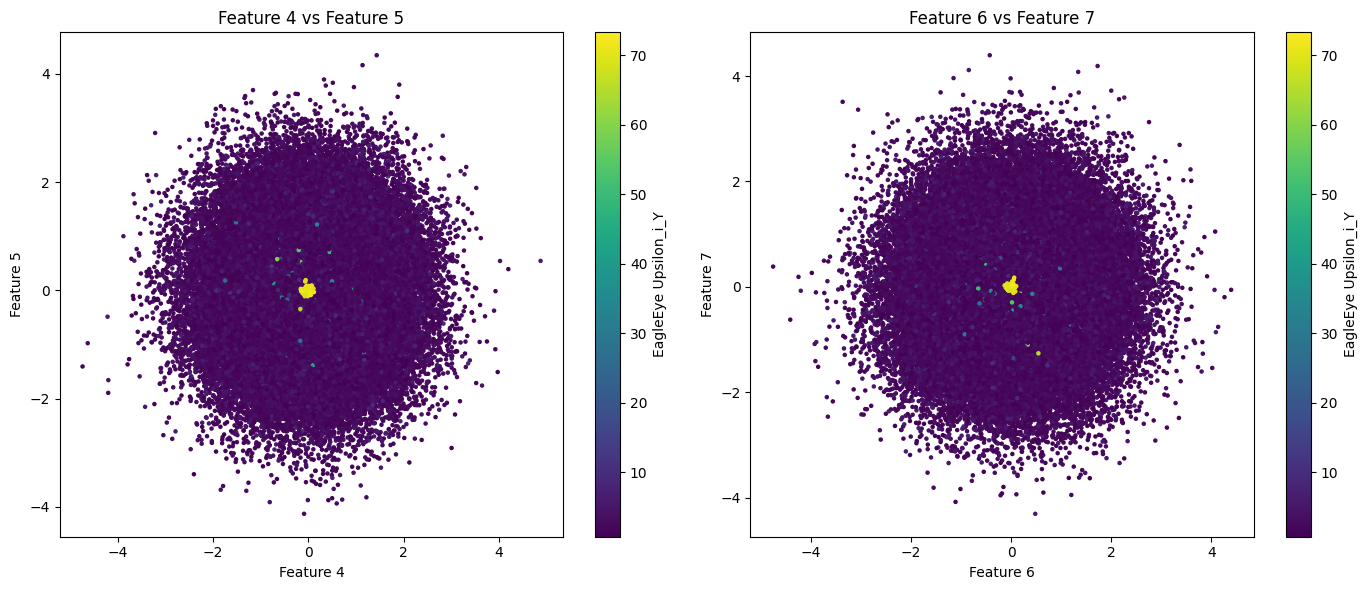

In [ ]:
# Scatter plots for first two features and last two features, colored by EagleEye anomaly score (Upsilon_i_Y)
upsilon = eagleeye_test_result[1]['Upsilon_i_Y']
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sc0 = axes[0].scatter(X_data[:, 0], X_data[:, 1], c=upsilon, cmap='viridis', s=5)
axes[0].set_xlabel('Feature 0')
axes[0].set_ylabel('Feature 1')
axes[0].set_title('Feature 0 vs Feature 1')
plt.colorbar(sc0, ax=axes[0], label='EagleEye Upsilon_i_Y')

sc1 = axes[1].scatter(X_data[:, 2], X_data[:, 3], c=upsilon, cmap='viridis', s=5)
axes[1].set_xlabel('Feature 2')
axes[1].set_ylabel('Feature 3')
axes[1].set_title('Feature 2 vs Feature 3')
plt.colorbar(sc1, ax=axes[1], label='EagleEye Upsilon_i_Y')
plt.tight_layout()
plt.savefig("./MLP_comp_plots/eagleeye_scatter_01_23.png")
plt.show()

# Scatter plots for other feature combinations, e.g., (4,5) and (6,7)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sc2 = axes[0].scatter(X_data[:, 4], X_data[:, 5], c=upsilon, cmap='viridis', s=5)
axes[0].set_xlabel('Feature 4')
axes[0].set_ylabel('Feature 5')
axes[0].set_title('Feature 4 vs Feature 5')
plt.colorbar(sc2, ax=axes[0], label='EagleEye Upsilon_i_Y')

sc3 = axes[1].scatter(X_data[:, 6], X_data[:, 7], c=upsilon, cmap='viridis', s=5)
axes[1].set_xlabel('Feature 6')
axes[1].set_ylabel('Feature 7')
axes[1].set_title('Feature 6 vs Feature 7')
plt.colorbar(sc3, ax=axes[1], label='EagleEye Upsilon_i_Y')

plt.tight_layout()
plt.savefig("./MLP_comp_plots/eagleeye_scatter_45_67.png")
plt.show()


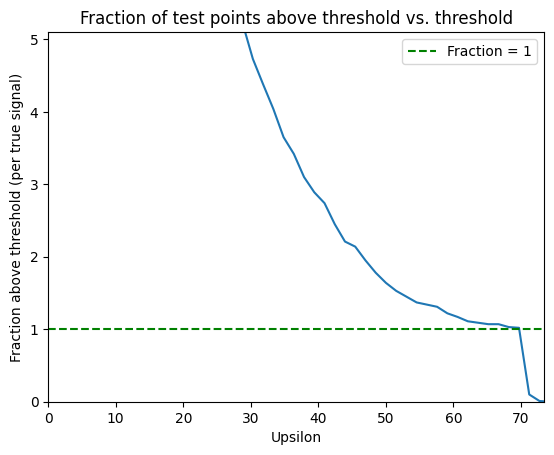

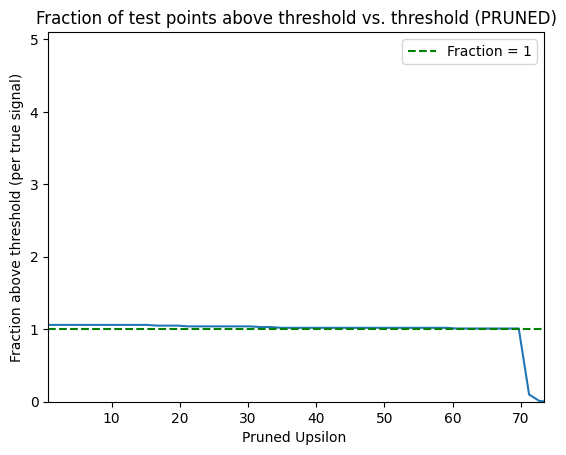

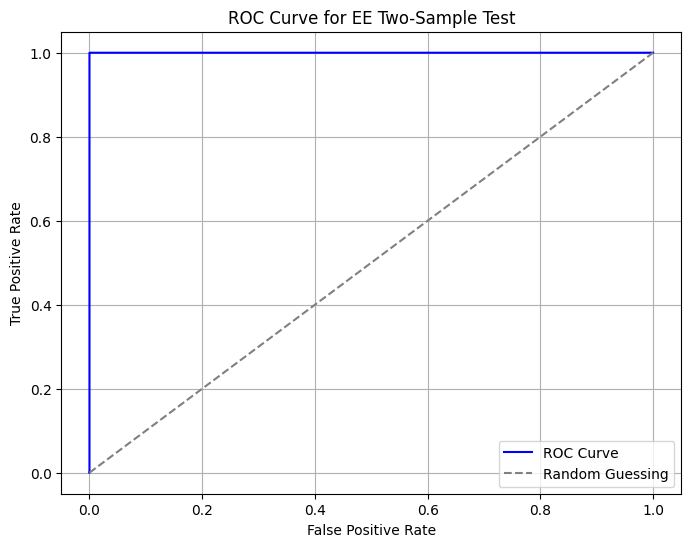

Total AUC: 0.99998265


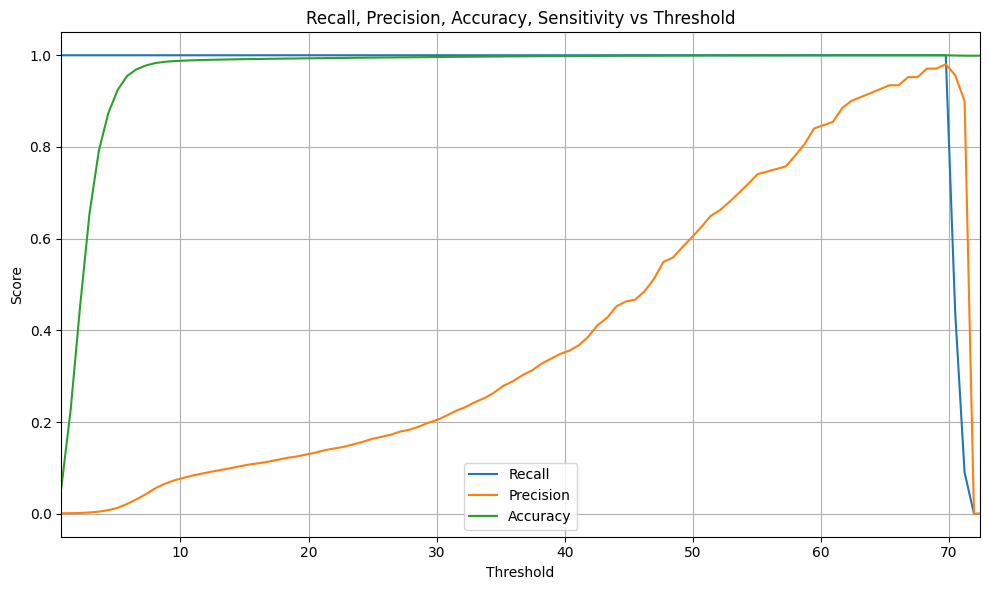

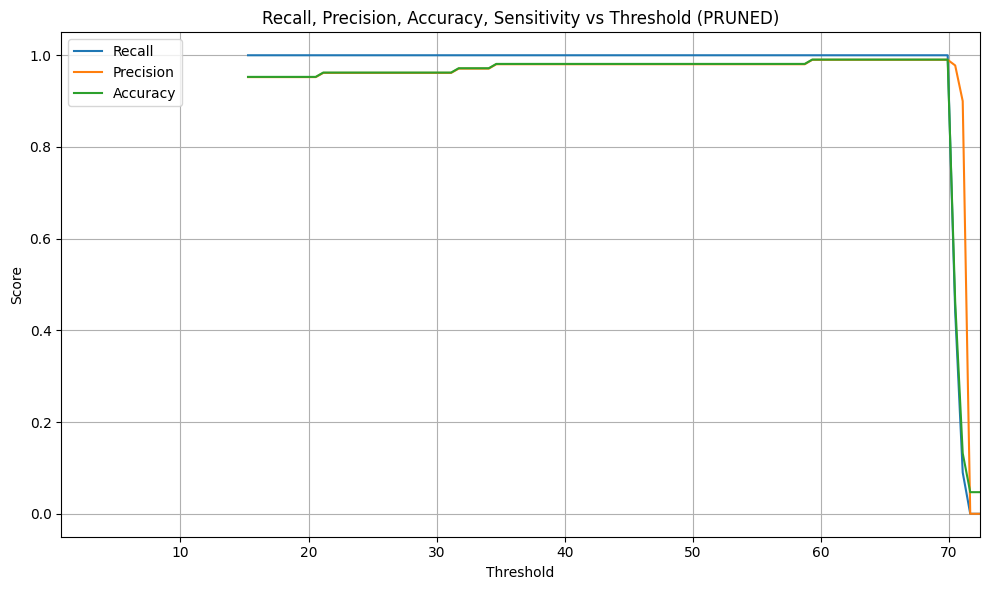

In [29]:

thresholds = np.linspace(0, 150, 100)
fractions = [np.sum(eagleeye_test_result[1]['Upsilon_i_Y']  > t) / np.sum(signal_labels==1) for t in thresholds]

plt.plot(thresholds, fractions)
plt.xlabel('Upsilon')
plt.ylabel('Fraction above threshold (per true signal)')
plt.title('Fraction of test points above threshold vs. threshold')
plt.axhline(1, color='green', linestyle='--', label='Fraction = 1')
plt.legend()
plt.ylim(0, 5.1)
plt.xlim(0, max(eagleeye_test_result[1]['Upsilon_i_Y']) )
plt.savefig("./MLP_comp_plots/eagleeye_fraction_vs_threshold.png")
plt.show()

thresholds = np.linspace(0, 150, 100)
fractions_pruned = [np.sum(eagleeye_test_result[1]['Upsilon_i_Y'][eagleeye_test_result[1]['Y_Pruned'][p_ext]]  > t) / np.sum(signal_labels==1) for t in thresholds]

plt.plot(thresholds, fractions_pruned)
plt.xlabel('Pruned Upsilon ')
plt.ylabel('Fraction above threshold (per true signal)')
plt.title('Fraction of test points above threshold vs. threshold (PRUNED)')
plt.axhline(1, color='green', linestyle='--', label='Fraction = 1')
plt.legend()
plt.ylim(0, 5.1)
plt.xlim(min(eagleeye_test_result[1]['Upsilon_i_Y']), max(eagleeye_test_result[1]['Upsilon_i_Y']))
plt.savefig("./MLP_comp_plots/eagleeye_fraction_vs_threshold_pruned.png")
plt.show()


# ROC curve 

from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(signal_labels, np.log10(eagleeye_test_result[1]['Upsilon_i_Y']))

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for EE Two-Sample Test')
plt.legend()
plt.grid()
plt.savefig("./MLP_comp_plots/eagleeye_roc_curve.png")
plt.show()
print("Total AUC:", roc_auc_score(signal_labels, np.log10(eagleeye_test_result[1]['Upsilon_i_Y'])))




thresholds = np.linspace(min(eagleeye_test_result[1]['Upsilon_i_Y']), max(eagleeye_test_result[1]['Upsilon_i_Y']), 100)
recall = []
precision = []
accuracy = []
sensitivity = []

for t in thresholds:
    preds = (eagleeye_test_result[1]['Upsilon_i_Y'] > t).astype(int)
    tp = np.sum((preds == 1) & (signal_labels == 1))
    fp = np.sum((preds == 1) & (signal_labels == 0))
    tn = np.sum((preds == 0) & (signal_labels == 0))
    fn = np.sum((preds == 0) & (signal_labels == 1))
    recall.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    precision.append(tp / (tp + fp) if (tp + fp) > 0 else 0)
    accuracy.append((tp + tn) / len(signal_labels))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, recall, label='Recall')
plt.plot(thresholds, precision, label='Precision')
plt.plot(thresholds, accuracy, label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Recall, Precision, Accuracy, Sensitivity vs Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(min(eagleeye_test_result[1]['Upsilon_i_Y']), max(eagleeye_test_result[1]['Upsilon_i_Y'])-1)
plt.savefig("./MLP_comp_plots/eagleeye_recall_precision_accuracy_vs_threshold.png")
plt.show()



thresholds = np.linspace(min(eagleeye_test_result[1]['Upsilon_i_Y'][eagleeye_test_result[1]['Y_Pruned'][p_ext]]), max(eagleeye_test_result[1]['Upsilon_i_Y'][eagleeye_test_result[1]['Y_Pruned'][p_ext]]), 100)
recall = []
precision = []
accuracy = []
sensitivity = []

for t in thresholds:
    preds = (eagleeye_test_result[1]['Upsilon_i_Y'][eagleeye_test_result[1]['Y_Pruned'][p_ext]] > t).astype(int)
    tp = np.sum((preds == 1) & (signal_labels[eagleeye_test_result[1]['Y_Pruned'][p_ext]] == 1))
    fp = np.sum((preds == 1) & (signal_labels[eagleeye_test_result[1]['Y_Pruned'][p_ext]] == 0))
    tn = np.sum((preds == 0) & (signal_labels[eagleeye_test_result[1]['Y_Pruned'][p_ext]] == 0))
    fn = np.sum((preds == 0) & (signal_labels[eagleeye_test_result[1]['Y_Pruned'][p_ext]] == 1))
    recall.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    precision.append(tp / (tp + fp) if (tp + fp) > 0 else 0)
    accuracy.append((tp + tn) / len(signal_labels[eagleeye_test_result[1]['Y_Pruned'][p_ext]]))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, recall, label='Recall')
plt.plot(thresholds, precision, label='Precision')
plt.plot(thresholds, accuracy, label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Recall, Precision, Accuracy, Sensitivity vs Threshold (PRUNED)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(min(eagleeye_test_result[1]['Upsilon_i_Y']), max(eagleeye_test_result[1]['Upsilon_i_Y'])-1)
plt.savefig("./MLP_comp_plots/eagleeye_recall_precision_accuracy_vs_threshold_pruned.png")
plt.show()

## MLP

In [4]:
auc = mlp_c2st_tf_gpu(X_ref, X_data,data_labels=signal_labels,batch_size=128)

lr, bce_loss_pt = extract_lr_scores(auc[1], auc[2], batch_size=1)

2025-07-02 14:50:11.968818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2025-07-02 14:50:20.656541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2025-07-02 14:51:09.673263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [5]:
auc[1].save('mlp_model_saved')
np.save('mlp_model_saved_scores.npy', np.array([lr, bce_loss_pt]))
# Save test labels
np.save('mlp_model_saved_labels.npy', auc[3])

INFO:tensorflow:Assets written to: mlp_model_saved/assets


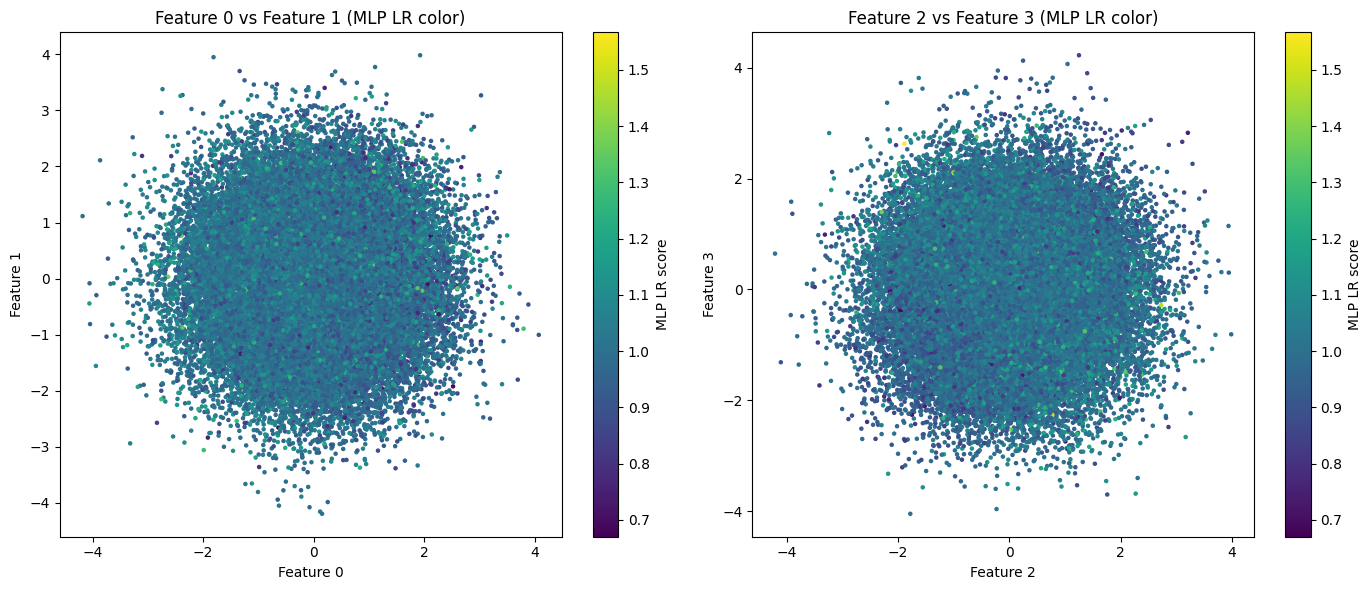

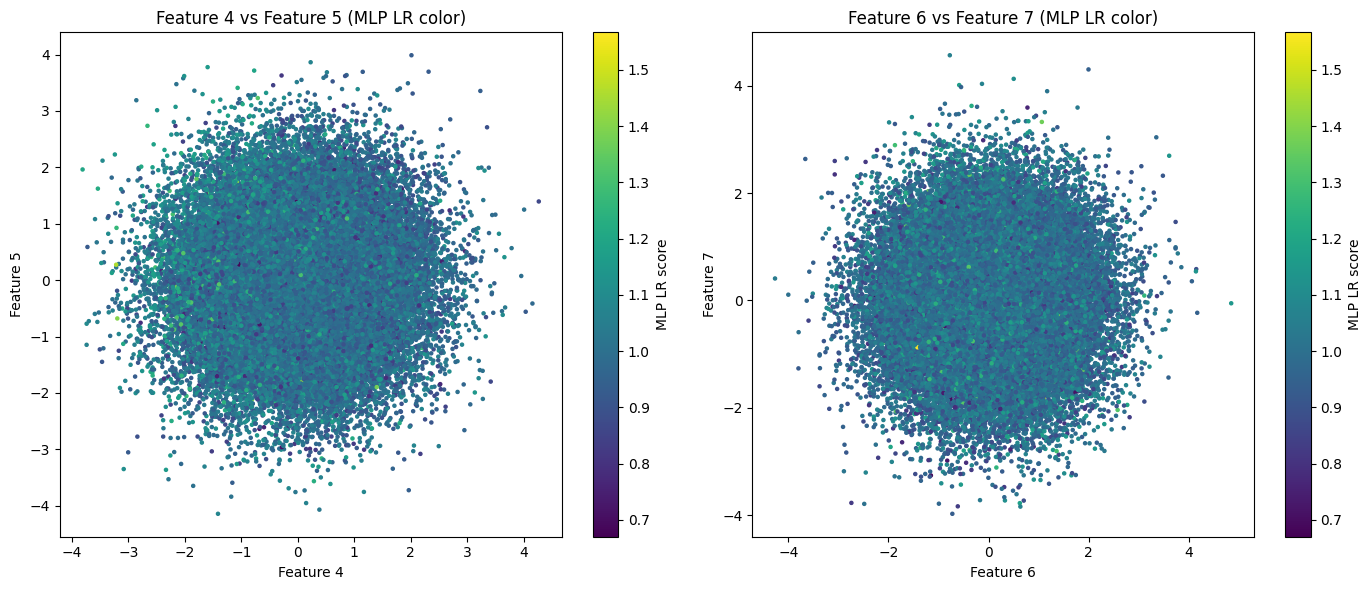

In [8]:
# Scatter plots for first two features and last two features, colored by MLP LR score
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sc0 = axes[0].scatter(auc[2][:, 0], auc[2][:, 1], c=lr, cmap='viridis', s=5)
axes[0].set_xlabel('Feature 0')
axes[0].set_ylabel('Feature 1')
axes[0].set_title('Feature 0 vs Feature 1 (MLP LR color)')
plt.colorbar(sc0, ax=axes[0], label='MLP LR score')

sc1 = axes[1].scatter(auc[2][:, 2], auc[2][:, 3], c=lr, cmap='viridis', s=5)
axes[1].set_xlabel('Feature 2')
axes[1].set_ylabel('Feature 3')
axes[1].set_title('Feature 2 vs Feature 3 (MLP LR color)')
plt.colorbar(sc1, ax=axes[1], label='MLP LR score')

plt.tight_layout()
fig.savefig("./MLP_comp_plots/mlp_scatter_01_23.png")
plt.show()

# Scatter plots for other feature combinations, e.g., (4,5) and (6,7)
fig2, axes2 = plt.subplots(1, 2, figsize=(14, 6))

sc2 = axes2[0].scatter(auc[2][:, 4], auc[2][:, 5], c=lr, cmap='viridis', s=5)
axes2[0].set_xlabel('Feature 4')
axes2[0].set_ylabel('Feature 5')
axes2[0].set_title('Feature 4 vs Feature 5 (MLP LR color)')
plt.colorbar(sc2, ax=axes2[0], label='MLP LR score')

sc3 = axes2[1].scatter(auc[2][:, 6], auc[2][:, 7], c=lr, cmap='viridis', s=5)
axes2[1].set_xlabel('Feature 6')
axes2[1].set_ylabel('Feature 7')
axes2[1].set_title('Feature 6 vs Feature 7 (MLP LR color)')
plt.colorbar(sc3, ax=axes2[1], label='MLP LR score')

plt.tight_layout()
fig2.savefig("./MLP_comp_plots/mlp_scatter_45_67.png")
plt.show()


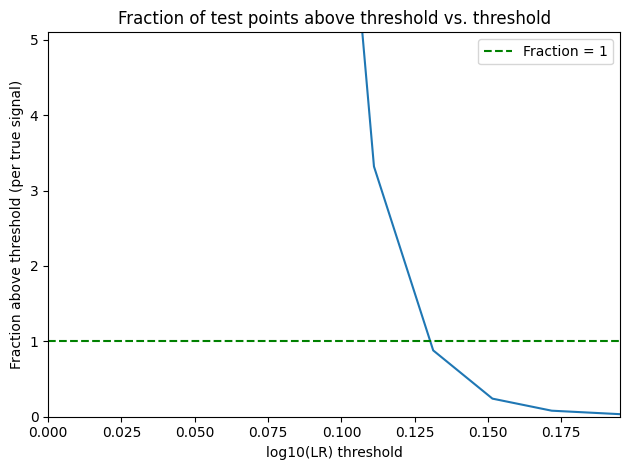

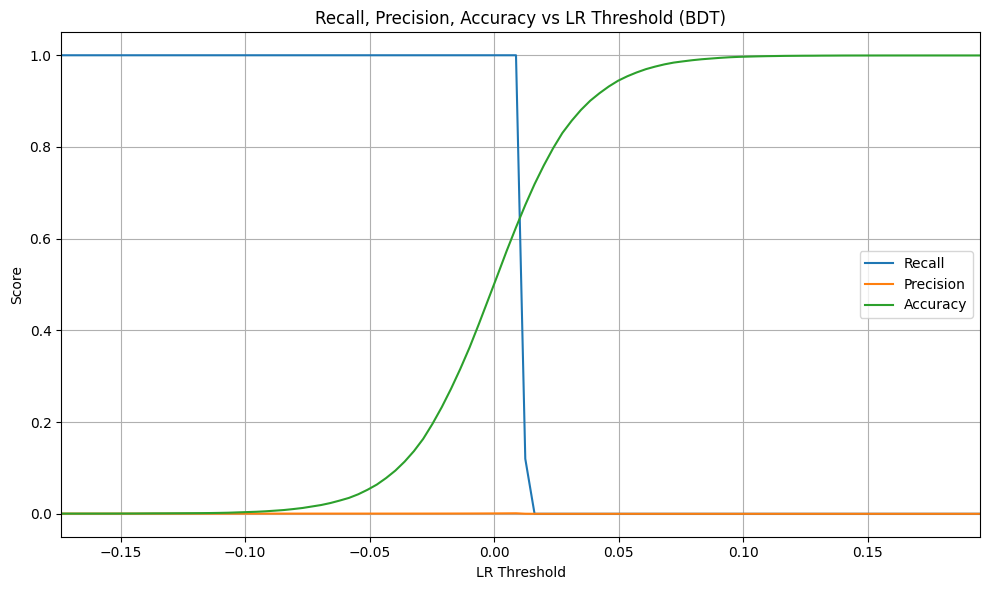

In [22]:
thresholds = np.linspace(-1, 1, 100)
fractions = [np.sum(np.log10(lr) > t) / np.sum(auc[3]) for t in thresholds]

fig3 = plt.figure()
plt.plot(thresholds, fractions)
plt.xlabel('log10(LR) threshold')
plt.ylabel('Fraction above threshold (per true signal)')
plt.title('Fraction of test points above threshold vs. threshold')
plt.axhline(1, color='green', linestyle='--', label='Fraction = 1')
plt.legend()
plt.ylim(0, 5.1)
plt.xlim(0, max(np.log10(lr)))
plt.tight_layout()
fig3.savefig("./MLP_comp_plots/mlp_fraction_vs_threshold.png")
plt.show()


#
# Compute recall, precision, and accuracy for the BDT likelihood ratio (lr)
thresholds_lr = np.linspace(min(np.log10(lr)), max(np.log10(lr)), 100)
recall_lr = []
precision_lr = []
accuracy_lr = []

signal_labels_MLP_tesdt_set = auc[3]

for t in thresholds_lr:
    preds = (np.log10(lr) > t).astype(int)
    tp = np.sum((preds == 1) & (signal_labels_MLP_tesdt_set == 1))
    fp = np.sum((preds == 1) & (signal_labels_MLP_tesdt_set == 0))
    tn = np.sum((preds == 0) & (signal_labels_MLP_tesdt_set == 0))
    fn = np.sum((preds == 0) & (signal_labels_MLP_tesdt_set == 1))
    recall_lr.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    precision_lr.append(tp / (tp + fp) if (tp + fp) > 0 else 0)
    accuracy_lr.append((tp + tn) / len(signal_labels_MLP_tesdt_set))

plt.figure(figsize=(10, 6))
plt.plot(thresholds_lr, recall_lr, label='Recall')
plt.plot(thresholds_lr, precision_lr, label='Precision')
plt.plot(thresholds_lr, accuracy_lr, label='Accuracy')
plt.xlabel('LR Threshold')
plt.ylabel('Score')
plt.title('Recall, Precision, Accuracy vs LR Threshold (BDT)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(min(np.log10(lr)), max(np.log10(lr)))
plt.savefig("./MLP_comp_plots/mlp_recall_precision_accuracy_vs_threshold.png")
plt.show()

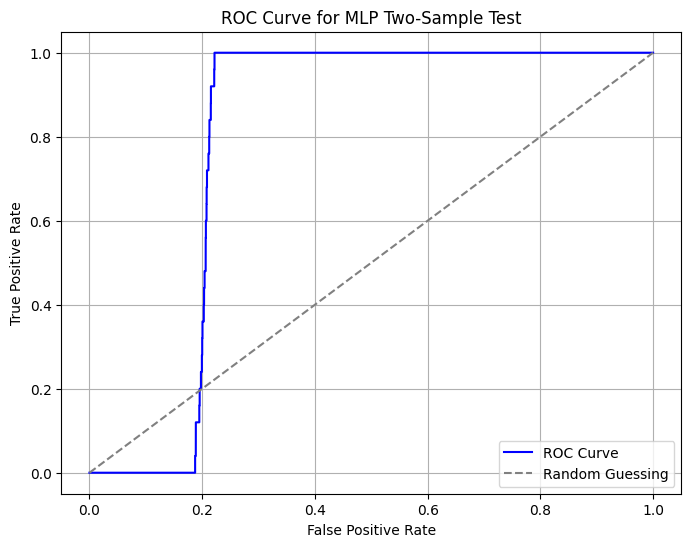

Accuracy at optimal ROC threshold: 0.7782
Total AUC: 0.7953


In [ ]:
# ROC curve 
h = plt.hist(lr, bins=100, density=True, alpha=0.5)
plt.yscale('log')
plt.savefig("./MLP_comp_plots/mlp_lr_hist.png")
plt.close()

from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(auc[3], lr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for MLP Two-Sample Test')
plt.legend()
plt.grid()
plt.savefig("./MLP_comp_plots/mlp_roc_curve.png")
plt.show()

# Compute accuracy at the optimal threshold (Youden's J statistic)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
y_pred = (lr >= optimal_threshold).astype(int)
accuracy = np.mean(y_pred == auc[3])
print(f"Accuracy at optimal ROC threshold: {accuracy:.4f}")
print(f"Total AUC: {roc_auc_score(auc[3], lr):.4f}")

# EagleEye vs. BDT

In [38]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import NearestNeighbors
from scipy.stats import binom

# ---------- generate data ----------
np.random.seed()  # for reproducibility
d, r = 10, 0.005
n_bg, n_sig = 300_000, 1000
X_bg = np.random.uniform(-1, 1, size=(n_bg, d))

v = np.ones((d,))/np.sqrt(d)
t = np.random.uniform(-1, 1, size=(n_sig, 1))        # position along the line
noise = np.random.normal(scale=r, size=(n_sig, d))   # orthogonal jitter
noise -= (noise @ v)[:, None] * v                    # project to plane ⟂ v
X_sig = t * v + noise

X_data             = np.vstack([X_bg, X_sig])
signal_labels      = np.hstack([np.zeros(n_bg), np.ones(n_sig)]) # Signal labels

X_ref = np.random.uniform(-1, 1, size=(n_bg, d))
y     = np.concatenate([np.zeros(len(X_ref)),np.ones(len(X_data))])

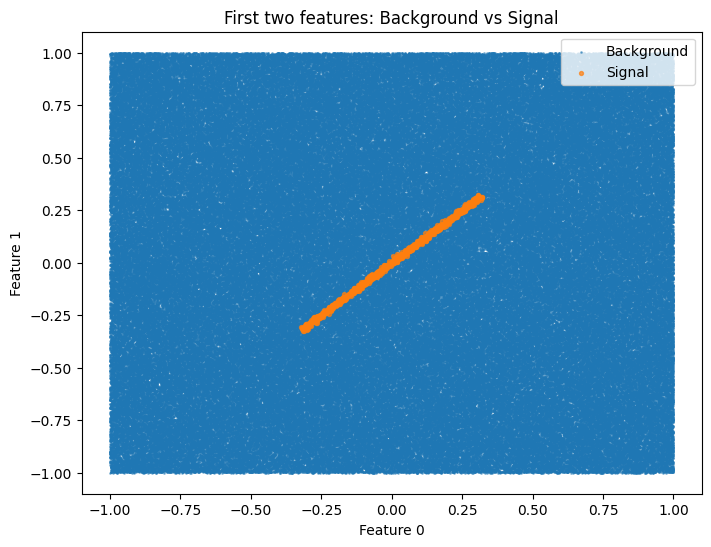

In [39]:
import matplotlib.pyplot as plt

# Plot the first two features, colored by label (background=0, signal=1)
plt.figure(figsize=(8, 6))
plt.scatter(X_data[signal_labels == 0, 0], X_data[signal_labels == 0, 1], s=1, alpha=0.5, label='Background')
plt.scatter(X_data[signal_labels == 1, 0], X_data[signal_labels == 1, 1], s=8, alpha=0.7, label='Signal')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.legend()
plt.title('First two features: Background vs Signal')
plt.show()

## BDT

In [47]:
from sklearn import tree
import graphviz

clf = GradientBoostingClassifier(
        n_estimators=200, max_depth=6, learning_rate=0.01,
        subsample=0.5, random_state=0)
clf.fit(np.concatenate([X_ref, X_data]), y)               # background vs data



GradientBoostingClassifier(learning_rate=0.01, max_depth=6, n_estimators=200,
                           random_state=0, subsample=0.5)

In [48]:
def extract_lr_from_bdt(bdt_model, x_data, eps=1e-12):
    """
    Compute likelihood ratio from BDT sigmoid output for input data.

    Parameters
    ----------
    bdt_model : trained classifier with predict_proba method
    x_data    : array-like, shape (n_samples, n_features)
    eps       : float, small value to avoid division by zero

    Returns
    -------
    lr : ndarray, likelihood ratio for each sample
    """
    # Get probability of class 1
    prob = bdt_model.predict_proba(x_data)[:, 1]
    return prob / (1 - prob + eps)

# Extract likelihood ratio from the BDT model
lr = extract_lr_from_bdt(clf, X_data)

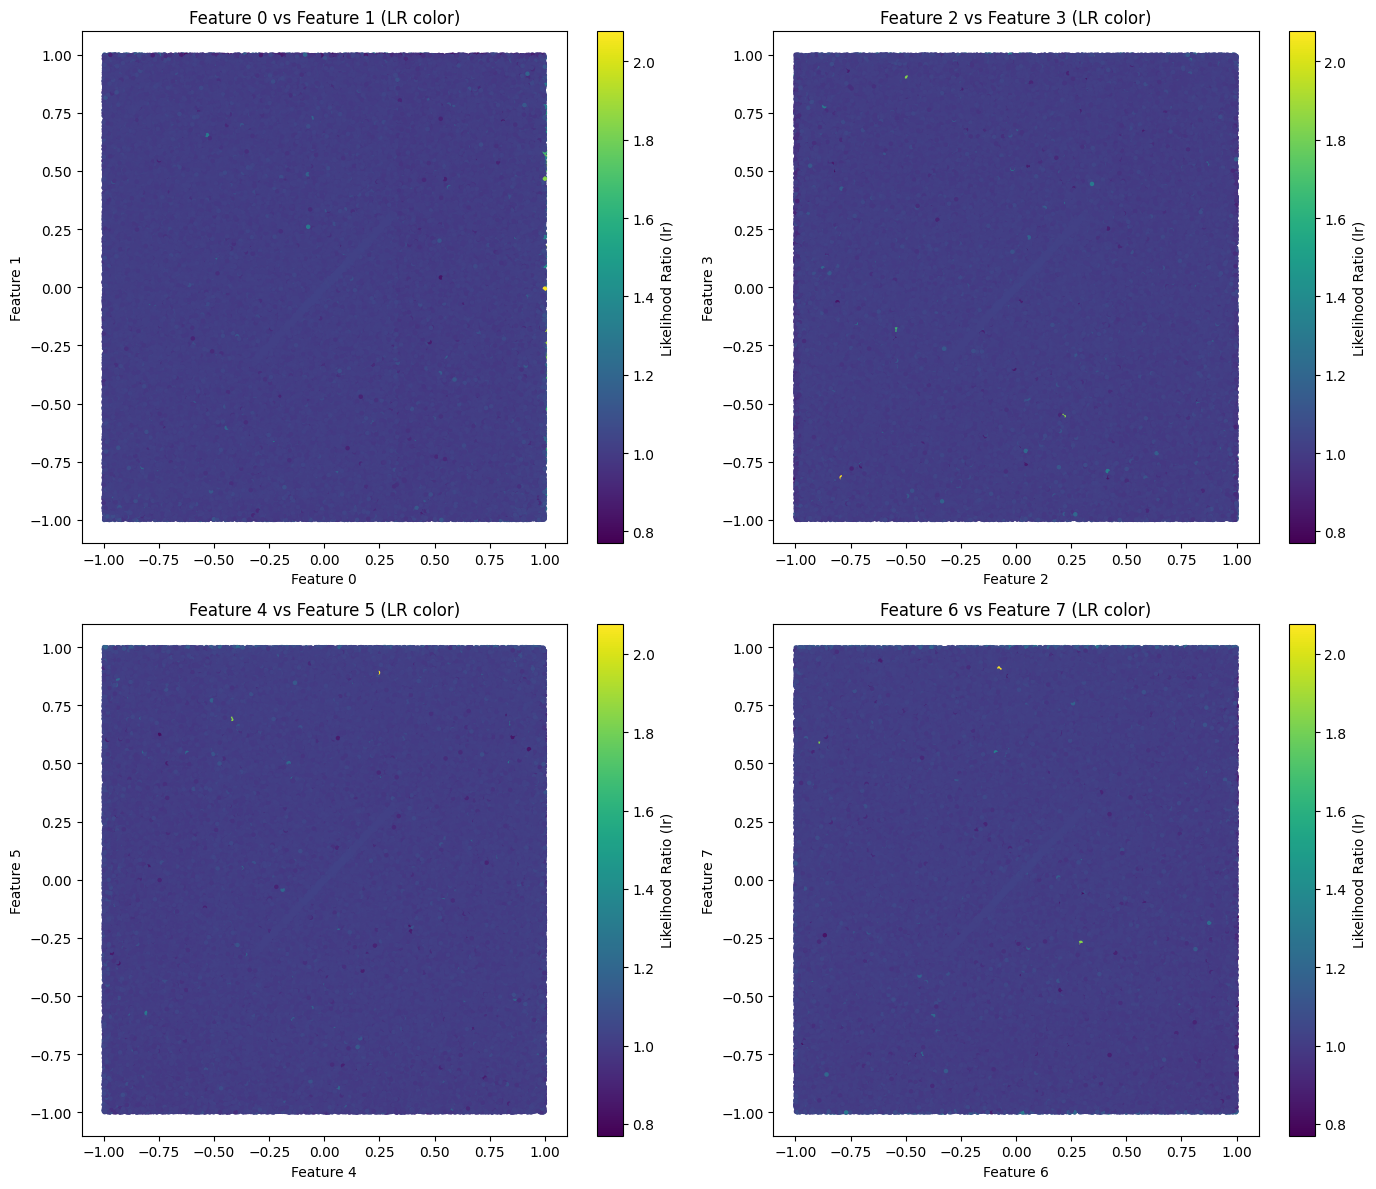

In [49]:
import matplotlib.pyplot as plt

# Plot feature pairs (0,1), (2,3), (4,5), (6,7) colored by lr
feature_pairs = [(0, 1), (2, 3), (4, 5), (6, 7)]
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for ax, (i, j) in zip(axes.ravel(), feature_pairs):
    sc = ax.scatter(X_data[:, i], X_data[:, j], c=lr, cmap='viridis', s=5)
    ax.set_xlabel(f'Feature {i}')
    ax.set_ylabel(f'Feature {j}')
    ax.set_title(f'Feature {i} vs Feature {j} (LR color)')
    plt.colorbar(sc, ax=ax, label='Likelihood Ratio (lr)')

plt.tight_layout()
plt.show()

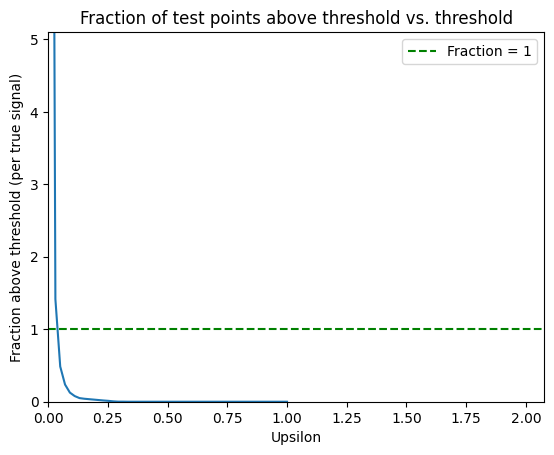

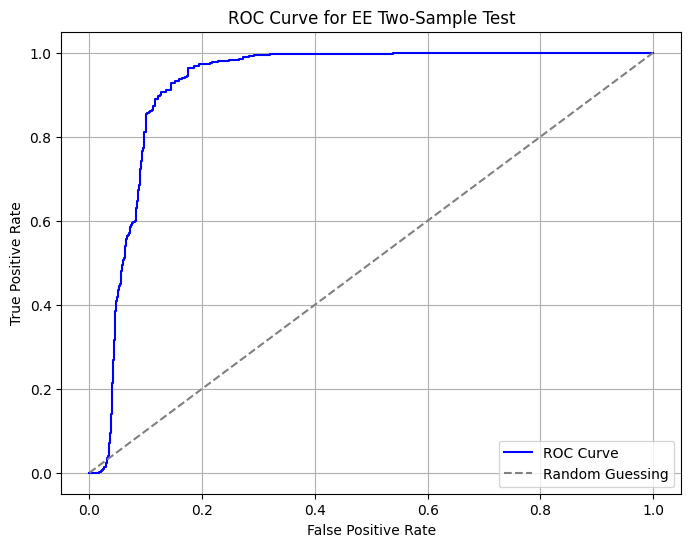

Total AUC: 0.9240719233333334


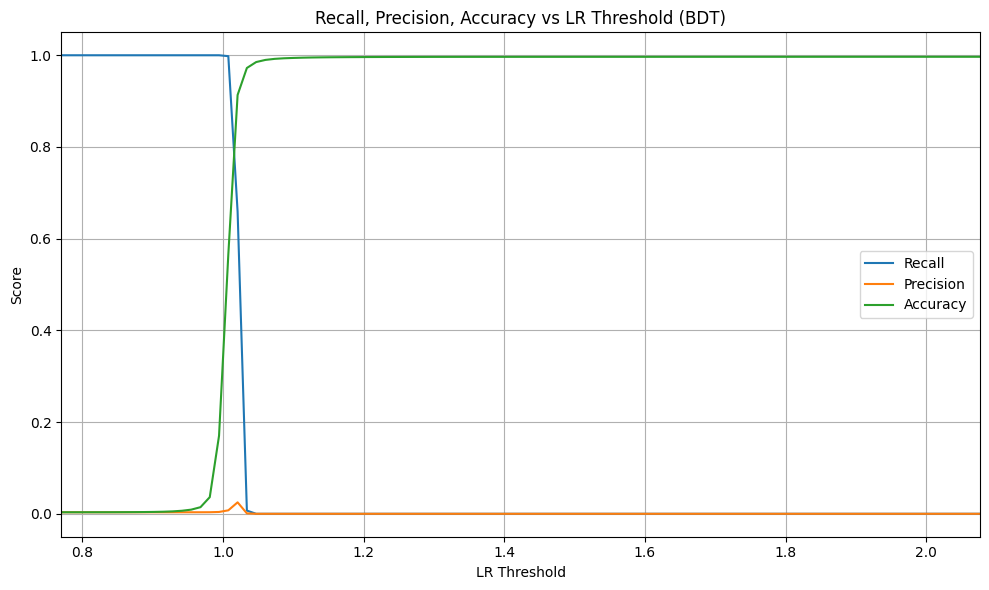

In [50]:
thresholds = np.linspace(-1, 1, 100)
fractions = [np.sum(np.log10(lr) > t) / np.sum(signal_labels) for t in thresholds]

plt.plot(thresholds, fractions)
plt.xlabel('Upsilon')
plt.ylabel('Fraction above threshold (per true signal)')
plt.title('Fraction of test points above threshold vs. threshold')
plt.axhline(1, color='green', linestyle='--', label='Fraction = 1')
plt.legend()
plt.ylim(0, 5.1)
plt.xlim(0, max(lr) )
plt.savefig("./MLP_comp_plots/eagleeye_fraction_vs_threshold.png")
plt.show()




# ROC curve 

from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(signal_labels, np.log10(lr))

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for EE Two-Sample Test')
plt.legend()
plt.grid()
plt.savefig("./MLP_comp_plots/eagleeye_roc_curve.png")
plt.show()
print("Total AUC:", roc_auc_score(signal_labels, np.log10(lr)))


#
# Compute recall, precision, and accuracy for the BDT likelihood ratio (lr)
thresholds_lr = np.linspace(min(lr), max(lr), 100)
recall_lr = []
precision_lr = []
accuracy_lr = []

for t in thresholds_lr:
    preds = (lr > t).astype(int)
    tp = np.sum((preds == 1) & (signal_labels == 1))
    fp = np.sum((preds == 1) & (signal_labels == 0))
    tn = np.sum((preds == 0) & (signal_labels == 0))
    fn = np.sum((preds == 0) & (signal_labels == 1))
    recall_lr.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    precision_lr.append(tp / (tp + fp) if (tp + fp) > 0 else 0)
    accuracy_lr.append((tp + tn) / len(signal_labels))

plt.figure(figsize=(10, 6))
plt.plot(thresholds_lr, recall_lr, label='Recall')
plt.plot(thresholds_lr, precision_lr, label='Precision')
plt.plot(thresholds_lr, accuracy_lr, label='Accuracy')
plt.xlabel('LR Threshold')
plt.ylabel('Score')
plt.title('Recall, Precision, Accuracy vs LR Threshold (BDT)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(min(lr), max(lr))
plt.show()

## EagleEye

In [13]:
p_ext = 1e-5
eagleeye_test_result = eagleeye_test(X_ref, X_data,do_IDE=True,p_ext=p_ext)


-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
KNN completed: 1.66 %
KNN completed: 3.33 %
KNN completed: 4.99 %
KNN completed: 6.66 %
KNN completed: 8.32 %
KNN completed: 9.98 %
KNN completed: 11.65 %
KNN completed: 13.31 %
KNN completed: 14.98 %
KNN completed: 16.64 %
KNN completed: 18.30 %
KNN completed: 19.97 %
KNN completed: 21.63 %
KNN completed: 23.29 %
KNN completed: 24.96 %
KNN completed: 26.62 %
KNN completed: 28.29 %
KNN completed: 29.95 %
KNN completed: 31.61 %
KNN completed: 33.28 %
KNN completed: 34.94 %
KNN completed: 36.61 %
KNN completed: 38.27 %
KNN completed: 39.93 %
KNN completed: 41.60 %
KNN completed: 43.26 %
KNN completed: 44.93 %
KNN completed: 46.59 %
KNN completed: 48.25 %
KNN completed: 49.92 %
KNN completed: 51.58 %
KNN completed: 53.24 %
KNN completed: 54.91 %
KNN completed: 56.57 %
KNN completed: 58.24 %
KN

<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Pruning via iterative density equalization (IDE)
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

Elapsed time: 327.50839495658875 seconds


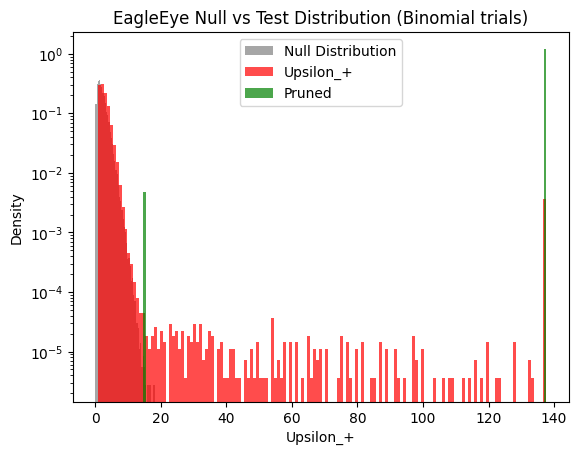

In [17]:
h = plt.hist(list(eagleeye_test_result[0].values())[0], bins=50, alpha=0.7, label='Null Distribution', color='grey', density=True)
h = plt.hist(eagleeye_test_result[1]['Upsilon_i_Y'], bins=150, alpha=0.7, label='Upsilon_+', color='red', density=True)
h = plt.hist(eagleeye_test_result[1]['Upsilon_i_Y'][eagleeye_test_result[1]['Y_Pruned'][p_ext]], bins=150, alpha=0.7, label='Pruned', color='green', density=True)

plt.yscale('log')
plt.xlabel('Upsilon_+')
plt.ylabel('Density')
plt.title('EagleEye Null vs Test Distribution (Binomial trials)')
plt.legend()
# plt.savefig("./MLP_comp_plots/eagleeye_null_vs_test_hist.png")
plt.show()

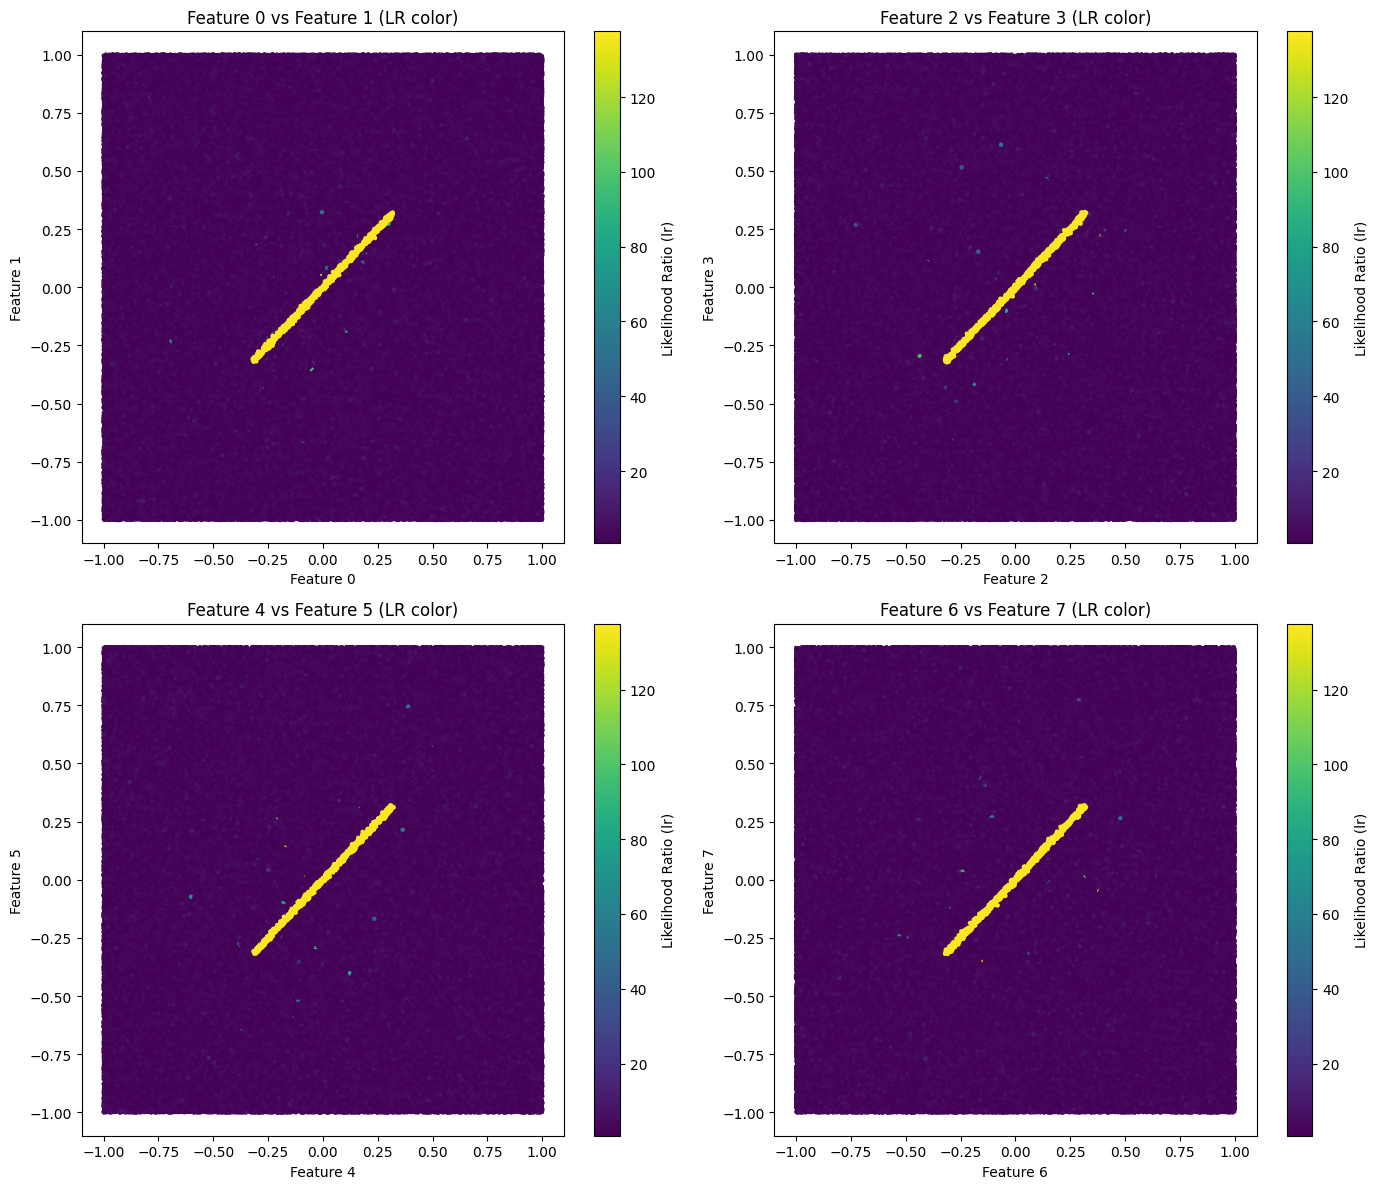

In [ ]:


import matplotlib.pyplot as plt

# Plot feature pairs (0,1), (2,3), (4,5), (6,7) colored by lr
feature_pairs = [(0, 1), (2, 3), (4, 5), (6, 7)]
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for ax, (i, j) in zip(axes.ravel(), feature_pairs):
    sc = ax.scatter(X_data[:, i], X_data[:, j], c=eagleeye_test_result[1]['Upsilon_i_Y'], cmap='viridis', s=5)
    ax.set_xlabel(f'Feature {i}')
    ax.set_ylabel(f'Feature {j}')
    ax.set_title(f'Feature {i} vs Feature {j} (LR color)')
    plt.colorbar(sc, ax=ax, label='Likelihood Ratio (lr)')

plt.tight_layout()
plt.show()

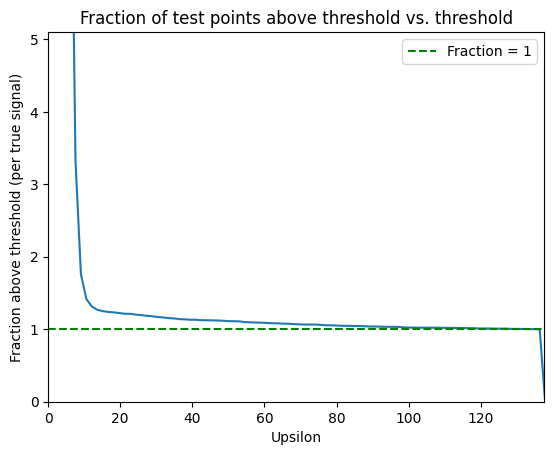

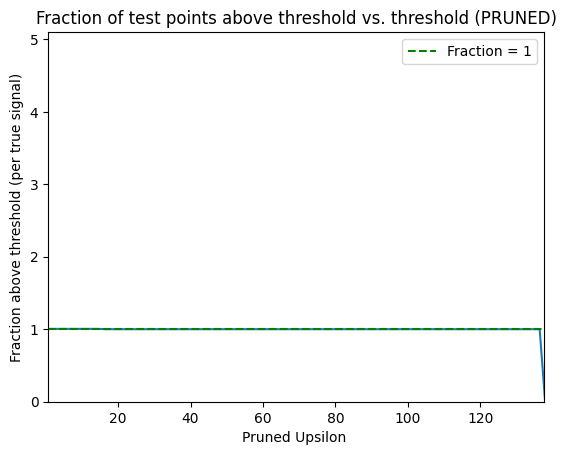

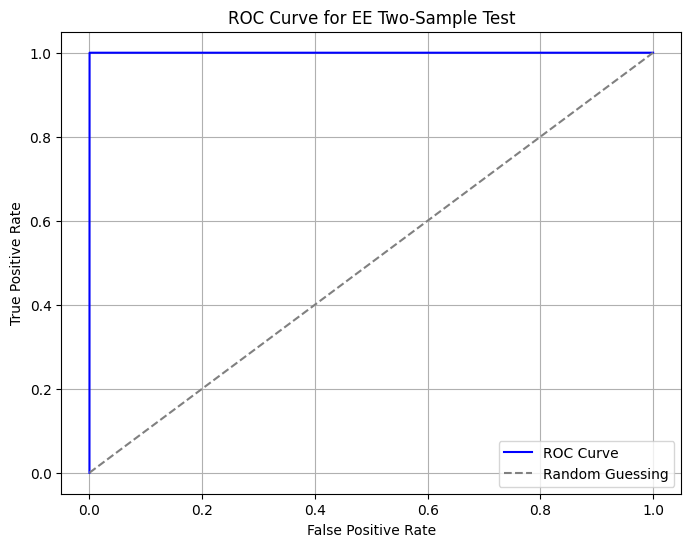

Total AUC: 0.9999983333333333


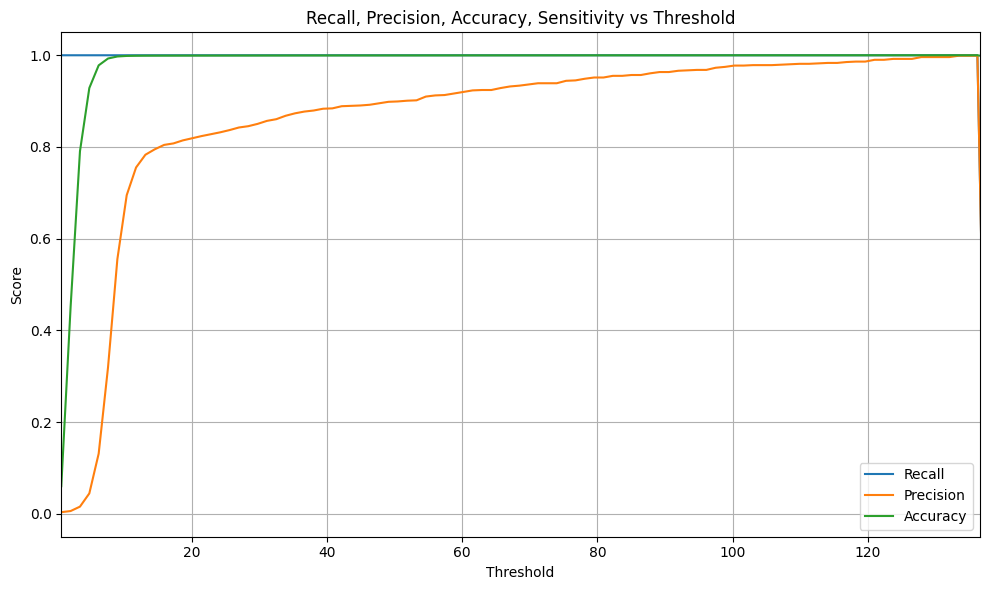

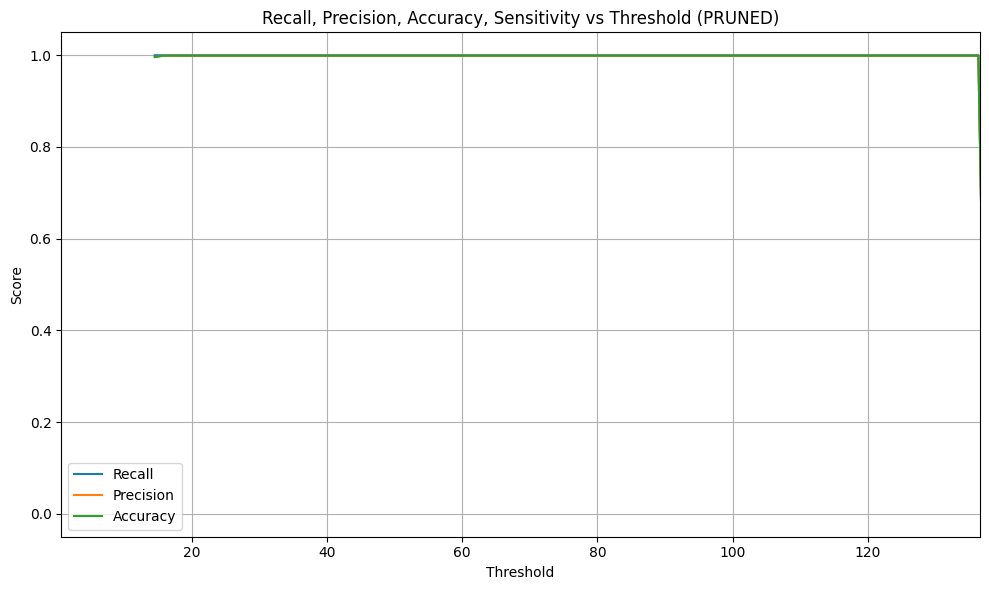

In [23]:
thresholds = np.linspace(0, 150, 100)
fractions = [np.sum(eagleeye_test_result[1]['Upsilon_i_Y']  > t) / np.sum(signal_labels==1) for t in thresholds]

plt.plot(thresholds, fractions)
plt.xlabel('Upsilon')
plt.ylabel('Fraction above threshold (per true signal)')
plt.title('Fraction of test points above threshold vs. threshold')
plt.axhline(1, color='green', linestyle='--', label='Fraction = 1')
plt.legend()
plt.ylim(0, 5.1)
plt.xlim(0, max(eagleeye_test_result[1]['Upsilon_i_Y']) )
plt.savefig("./MLP_comp_plots/eagleeye_fraction_vs_threshold.png")
plt.show()

thresholds = np.linspace(0, 150, 100)
fractions_pruned = [np.sum(eagleeye_test_result[1]['Upsilon_i_Y'][eagleeye_test_result[1]['Y_Pruned'][p_ext]]  > t) / np.sum(signal_labels==1) for t in thresholds]

plt.plot(thresholds, fractions_pruned)
plt.xlabel('Pruned Upsilon ')
plt.ylabel('Fraction above threshold (per true signal)')
plt.title('Fraction of test points above threshold vs. threshold (PRUNED)')
plt.axhline(1, color='green', linestyle='--', label='Fraction = 1')
plt.legend()
plt.ylim(0, 5.1)
plt.xlim(min(eagleeye_test_result[1]['Upsilon_i_Y']), max(eagleeye_test_result[1]['Upsilon_i_Y']))
plt.savefig("./MLP_comp_plots/eagleeye_fraction_vs_threshold_pruned.png")
plt.show()


# ROC curve 

from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(signal_labels, np.log10(eagleeye_test_result[1]['Upsilon_i_Y']))

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for EE Two-Sample Test')
plt.legend()
plt.grid()
plt.savefig("./MLP_comp_plots/eagleeye_roc_curve.png")
plt.show()
print("Total AUC:", roc_auc_score(signal_labels, np.log10(eagleeye_test_result[1]['Upsilon_i_Y'])))



thresholds = np.linspace(min(eagleeye_test_result[1]['Upsilon_i_Y']), max(eagleeye_test_result[1]['Upsilon_i_Y']), 100)
recall = []
precision = []
accuracy = []
sensitivity = []

for t in thresholds:
    preds = (eagleeye_test_result[1]['Upsilon_i_Y'] > t).astype(int)
    tp = np.sum((preds == 1) & (signal_labels == 1))
    fp = np.sum((preds == 1) & (signal_labels == 0))
    tn = np.sum((preds == 0) & (signal_labels == 0))
    fn = np.sum((preds == 0) & (signal_labels == 1))
    recall.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    precision.append(tp / (tp + fp) if (tp + fp) > 0 else 0)
    accuracy.append((tp + tn) / len(signal_labels))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, recall, label='Recall')
plt.plot(thresholds, precision, label='Precision')
plt.plot(thresholds, accuracy, label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Recall, Precision, Accuracy, Sensitivity vs Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(min(eagleeye_test_result[1]['Upsilon_i_Y']), max(eagleeye_test_result[1]['Upsilon_i_Y'])-1)
plt.show()



thresholds = np.linspace(min(eagleeye_test_result[1]['Upsilon_i_Y'][eagleeye_test_result[1]['Y_Pruned'][p_ext]]), max(eagleeye_test_result[1]['Upsilon_i_Y'][eagleeye_test_result[1]['Y_Pruned'][p_ext]]), 100)
recall = []
precision = []
accuracy = []
sensitivity = []

for t in thresholds:
    preds = (eagleeye_test_result[1]['Upsilon_i_Y'][eagleeye_test_result[1]['Y_Pruned'][p_ext]] > t).astype(int)
    tp = np.sum((preds == 1) & (signal_labels[eagleeye_test_result[1]['Y_Pruned'][p_ext]] == 1))
    fp = np.sum((preds == 1) & (signal_labels[eagleeye_test_result[1]['Y_Pruned'][p_ext]] == 0))
    tn = np.sum((preds == 0) & (signal_labels[eagleeye_test_result[1]['Y_Pruned'][p_ext]] == 0))
    fn = np.sum((preds == 0) & (signal_labels[eagleeye_test_result[1]['Y_Pruned'][p_ext]] == 1))
    recall.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    precision.append(tp / (tp + fp) if (tp + fp) > 0 else 0)
    accuracy.append((tp + tn) / len(signal_labels[eagleeye_test_result[1]['Y_Pruned'][p_ext]]))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, recall, label='Recall')
plt.plot(thresholds, precision, label='Precision')
plt.plot(thresholds, accuracy, label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Recall, Precision, Accuracy, Sensitivity vs Threshold (PRUNED)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(min(eagleeye_test_result[1]['Upsilon_i_Y']), max(eagleeye_test_result[1]['Upsilon_i_Y'])-1)
plt.show()

# EagleEye vs kernal method


In [2]:
import numpy as np

# ---------- parameters ----------
d, n_bg, n_sig = 3, 50_000, 5000
R, delta = 0.6, 0.02

# ---------- background ----------
X_bg = np.random.uniform(-1, 1, size=(n_bg, d))

# ---------- 3D spiral signal ----------
t = np.linspace(0, 4 * np.pi, n_sig).reshape(-1, 1)  # parameter along the spiral
x_spiral = (R * np.cos(t) + np.random.normal(0, delta, size=(n_sig, 1)))
y_spiral = (R * np.sin(t) + np.random.normal(0, delta, size=(n_sig, 1)))
z_spiral = (t / (4 * np.pi) * 2 - 1) + np.random.normal(0, delta, size=(n_sig, 1))  # z from -1 to 1

X_sig = np.hstack([x_spiral, y_spiral, z_spiral])

X_data = np.vstack([X_bg, X_sig])
signal_labels = np.hstack([np.zeros(n_bg), np.ones(n_sig)])      # 1 =data, 0 =MC

X_ref = np.random.uniform(-1, 1, size=(n_bg, d))


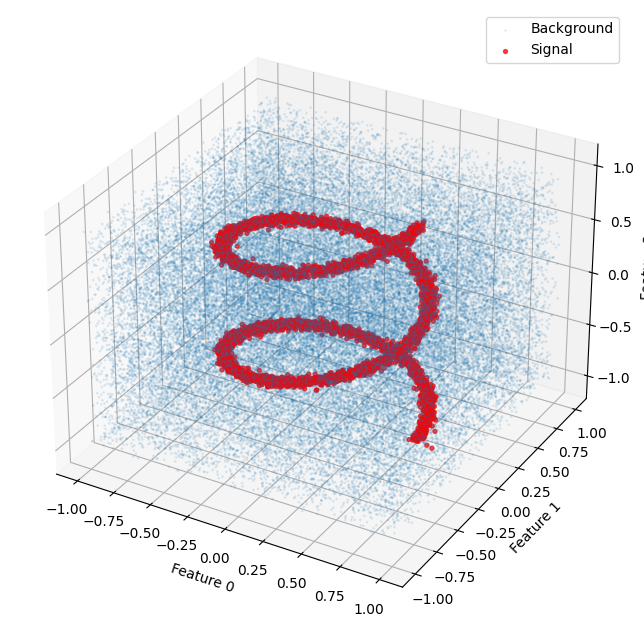

In [3]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_bg[:, 0], X_bg[:, 1], X_bg[:, 2], s=1, alpha=0.1, label='Background')
ax.scatter(X_sig[:, 0], X_sig[:, 1], X_sig[:, 2], s=8, alpha=0.7, label='Signal',color='red')
ax.set_xlabel('Feature 0')
ax.set_ylabel('Feature 1')
ax.set_zlabel('Feature 2')
ax.legend()
plt.show()


In [4]:
p_ext = 1e-5
eagleeye_test_result = eagleeye_test(X_ref, X_data,do_IDE=True,p_ext=p_ext)


-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
KNN completed: 9.52 %
KNN completed: 19.05 %
KNN completed: 28.57 %
KNN completed: 38.10 %
KNN completed: 47.62 %
KNN completed: 57.14 %
KNN completed: 66.67 %
KNN completed: 76.19 %
KNN completed: 85.71 %
KNN completed: 95.24 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Pruning via iterative density equalization (IDE)
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

Elapsed time: 269.58637404441833 seconds


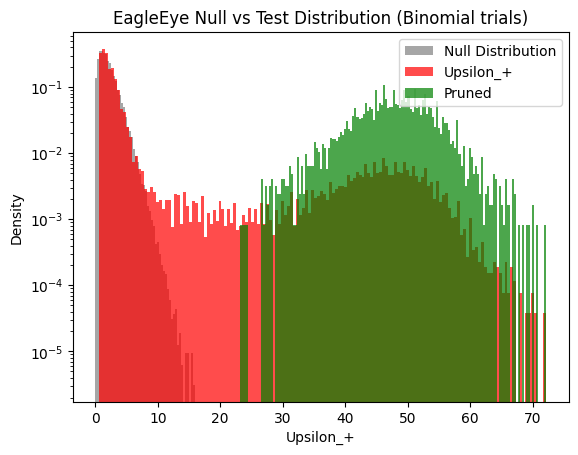

In [5]:

h = plt.hist(list(eagleeye_test_result[0].values())[0], bins=50, alpha=0.7, label='Null Distribution', color='grey', density=True)
h = plt.hist(eagleeye_test_result[1]['Upsilon_i_Y'], bins=150, alpha=0.7, label='Upsilon_+', color='red', density=True)
h = plt.hist(eagleeye_test_result[1]['Upsilon_i_Y'][eagleeye_test_result[1]['Y_Pruned'][p_ext]], bins=150, alpha=0.7, label='Pruned', color='green', density=True)

plt.yscale('log')
plt.xlabel('Upsilon_+')
plt.ylabel('Density')
plt.title('EagleEye Null vs Test Distribution (Binomial trials)')
plt.legend()
# plt.savefig("./MLP_comp_plots/eagleeye_null_vs_test_hist.png")
plt.show()


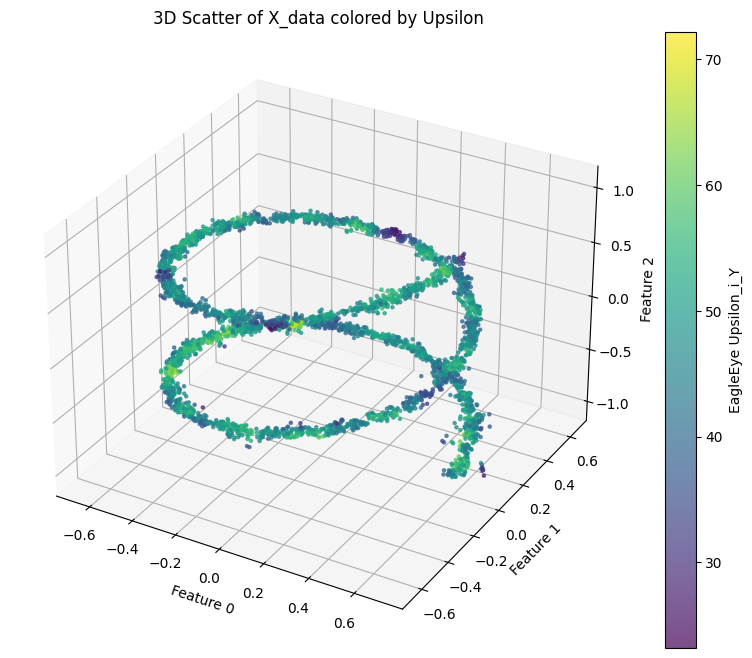

In [27]:
from mpl_toolkits.mplot3d import Axes3D

thresh = eagleeye_test_result[1]['Upsilon_i_Y'] > 0
thresh = eagleeye_test_result[1]['Y_Pruned'][p_ext]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_data[:, 0][thresh], X_data[:, 1][thresh], X_data[:, 2][thresh], c=eagleeye_test_result[1]['Upsilon_i_Y'][thresh], cmap='viridis', s=5,alpha=0.7)
ax.set_xlabel('Feature 0')
ax.set_ylabel('Feature 1')
ax.set_zlabel('Feature 2')
plt.colorbar(sc, ax=ax, label='EagleEye Upsilon_i_Y')
plt.title('3D Scatter of X_data colored by Upsilon')
plt.show()


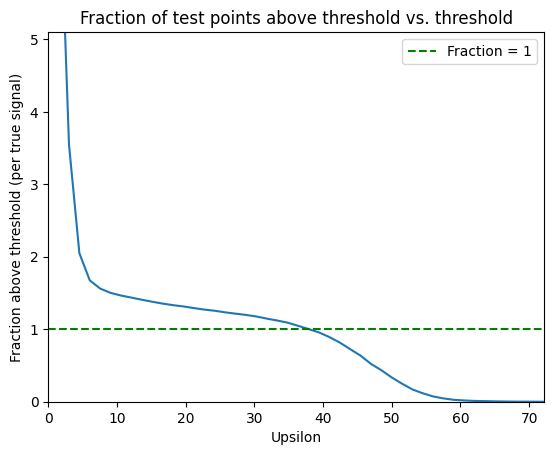

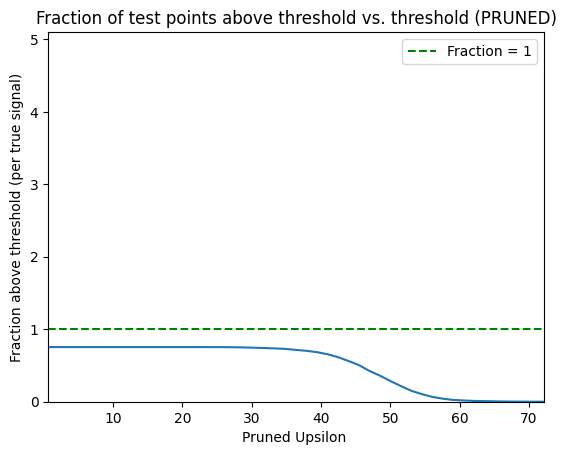

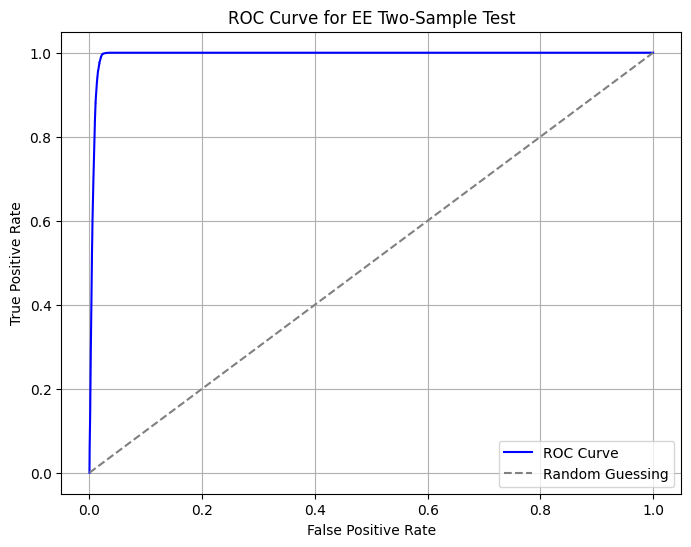

Total AUC: 0.9944599700000001


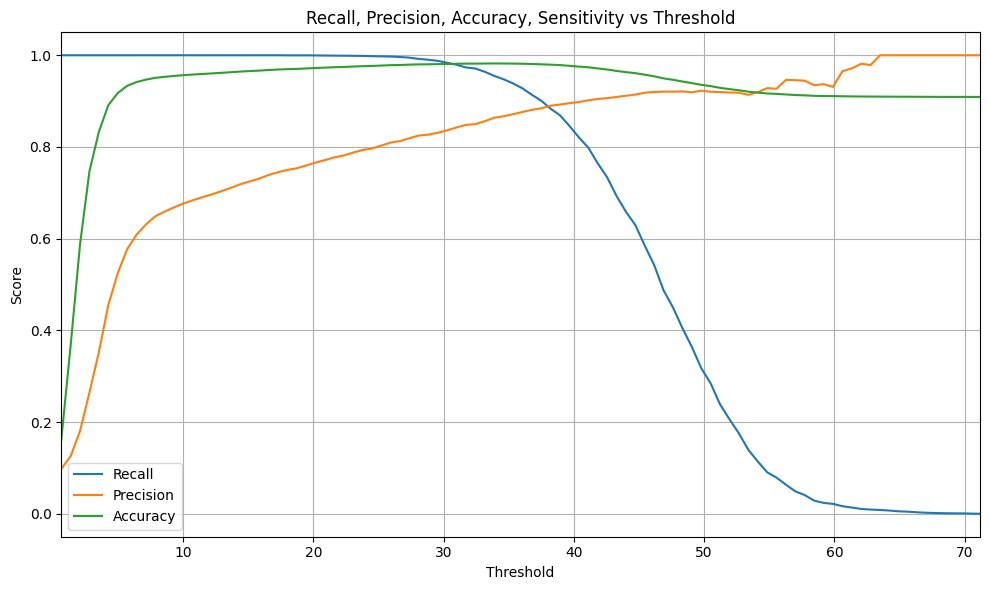

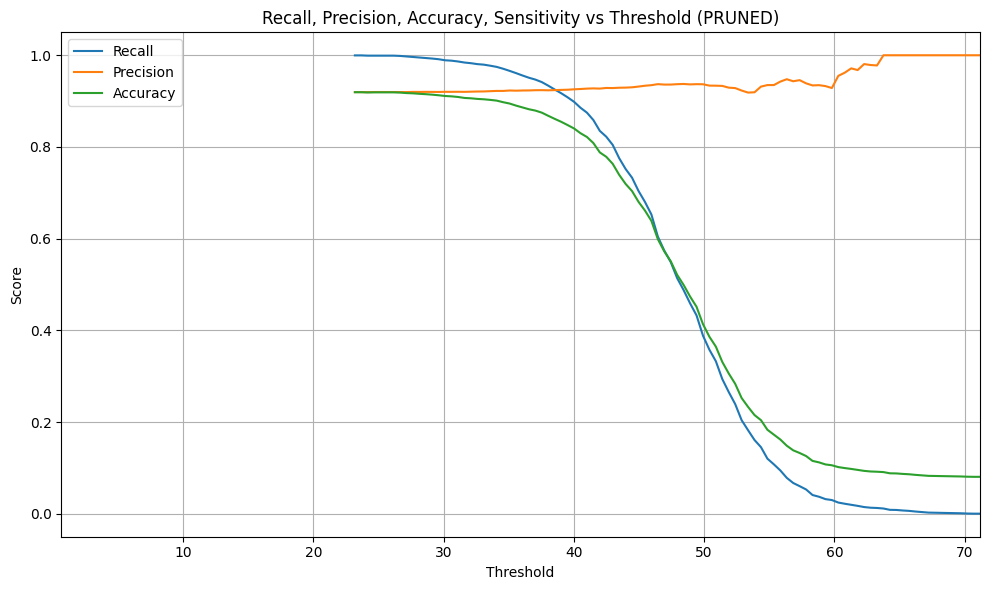

In [7]:
thresholds = np.linspace(0, 150, 100)
fractions = [np.sum(eagleeye_test_result[1]['Upsilon_i_Y']  > t) / np.sum(signal_labels==1) for t in thresholds]

plt.plot(thresholds, fractions)
plt.xlabel('Upsilon')
plt.ylabel('Fraction above threshold (per true signal)')
plt.title('Fraction of test points above threshold vs. threshold')
plt.axhline(1, color='green', linestyle='--', label='Fraction = 1')
plt.legend()
plt.ylim(0, 5.1)
plt.xlim(0, max(eagleeye_test_result[1]['Upsilon_i_Y']) )
plt.savefig("./MLP_comp_plots/eagleeye_fraction_vs_threshold.png")
plt.show()

thresholds = np.linspace(0, 150, 100)
fractions_pruned = [np.sum(eagleeye_test_result[1]['Upsilon_i_Y'][eagleeye_test_result[1]['Y_Pruned'][p_ext]]  > t) / np.sum(signal_labels==1) for t in thresholds]

plt.plot(thresholds, fractions_pruned)
plt.xlabel('Pruned Upsilon ')
plt.ylabel('Fraction above threshold (per true signal)')
plt.title('Fraction of test points above threshold vs. threshold (PRUNED)')
plt.axhline(1, color='green', linestyle='--', label='Fraction = 1')
plt.legend()
plt.ylim(0, 5.1)
plt.xlim(min(eagleeye_test_result[1]['Upsilon_i_Y']), max(eagleeye_test_result[1]['Upsilon_i_Y']))
plt.savefig("./MLP_comp_plots/eagleeye_fraction_vs_threshold_pruned.png")
plt.show()


# ROC curve 

from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(signal_labels, np.log10(eagleeye_test_result[1]['Upsilon_i_Y']))

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for EE Two-Sample Test')
plt.legend()
plt.grid()
plt.savefig("./MLP_comp_plots/eagleeye_roc_curve.png")
plt.show()
print("Total AUC:", roc_auc_score(signal_labels, np.log10(eagleeye_test_result[1]['Upsilon_i_Y'])))



thresholds = np.linspace(min(eagleeye_test_result[1]['Upsilon_i_Y']), max(eagleeye_test_result[1]['Upsilon_i_Y']), 100)
recall = []
precision = []
accuracy = []
sensitivity = []

for t in thresholds:
    preds = (eagleeye_test_result[1]['Upsilon_i_Y'] > t).astype(int)
    tp = np.sum((preds == 1) & (signal_labels == 1))
    fp = np.sum((preds == 1) & (signal_labels == 0))
    tn = np.sum((preds == 0) & (signal_labels == 0))
    fn = np.sum((preds == 0) & (signal_labels == 1))
    recall.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    precision.append(tp / (tp + fp) if (tp + fp) > 0 else 0)
    accuracy.append((tp + tn) / len(signal_labels))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, recall, label='Recall')
plt.plot(thresholds, precision, label='Precision')
plt.plot(thresholds, accuracy, label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Recall, Precision, Accuracy, Sensitivity vs Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(min(eagleeye_test_result[1]['Upsilon_i_Y']), max(eagleeye_test_result[1]['Upsilon_i_Y'])-1)
plt.show()



thresholds = np.linspace(min(eagleeye_test_result[1]['Upsilon_i_Y'][eagleeye_test_result[1]['Y_Pruned'][p_ext]]), max(eagleeye_test_result[1]['Upsilon_i_Y'][eagleeye_test_result[1]['Y_Pruned'][p_ext]]), 100)
recall = []
precision = []
accuracy = []
sensitivity = []

for t in thresholds:
    preds = (eagleeye_test_result[1]['Upsilon_i_Y'][eagleeye_test_result[1]['Y_Pruned'][p_ext]] > t).astype(int)
    tp = np.sum((preds == 1) & (signal_labels[eagleeye_test_result[1]['Y_Pruned'][p_ext]] == 1))
    fp = np.sum((preds == 1) & (signal_labels[eagleeye_test_result[1]['Y_Pruned'][p_ext]] == 0))
    tn = np.sum((preds == 0) & (signal_labels[eagleeye_test_result[1]['Y_Pruned'][p_ext]] == 0))
    fn = np.sum((preds == 0) & (signal_labels[eagleeye_test_result[1]['Y_Pruned'][p_ext]] == 1))
    recall.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    precision.append(tp / (tp + fp) if (tp + fp) > 0 else 0)
    accuracy.append((tp + tn) / len(signal_labels[eagleeye_test_result[1]['Y_Pruned'][p_ext]]))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, recall, label='Recall')
plt.plot(thresholds, precision, label='Precision')
plt.plot(thresholds, accuracy, label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Recall, Precision, Accuracy, Sensitivity vs Threshold (PRUNED)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(min(eagleeye_test_result[1]['Upsilon_i_Y']), max(eagleeye_test_result[1]['Upsilon_i_Y'])-1)
plt.show()

## Wavelets

In [9]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
import numpy as np

# ---- stack reference + data samples exactly as for the GP ----
X = np.vstack([X_ref, X_data])          # 100 k × 3 in your numbers
y = np.hstack([np.zeros(len(X_ref)),    # 0 = reference
               np.ones(len(X_data))])   # 1 = data (bg+spiral)

# --- 1. explicit RBF feature map -------------------------------
# heuristic γ: inverse median pair distance on a 10k subsample
sub = np.random.choice(len(X), 10_000, replace=False)
med = np.median(
    np.linalg.norm(X[sub][:,None,:] - X[sub][None,:,:], axis=-1))
gamma = 1.0 / (2*med**2)               # ~1.0 works fine in 3-D

feat = RBFSampler(gamma=gamma, n_components=4000, random_state=0)
X_phi = feat.fit_transform(X)          # 100 k × 4 k dense matrix
                                        #  ≈ 3.2 × 10⁸ floats → 1.3 GB
# --- 2. linear logistic in feature space -----------------------
clf = SGDClassifier(loss="log_loss", class_weight="balanced",
                    max_iter=20, tol=1e-3, random_state=0)
clf.fit(X_phi, y)

probs = clf.predict_proba(X_phi[len(X_ref):])[:,1]     # only on X_data
print("AUROC :", roc_auc_score(signal_labels, probs))

AUROC : 0.712168948


In [10]:
lr = probs / (1 - probs + 1e-12)  # likelihood ratio

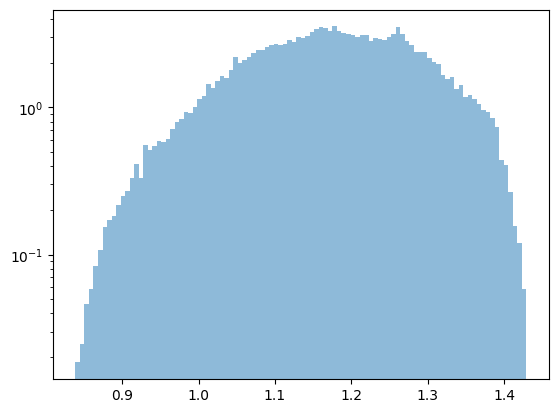

In [13]:
plt.hist(lr, bins=100, density=True, alpha=0.5)
plt.yscale('log')

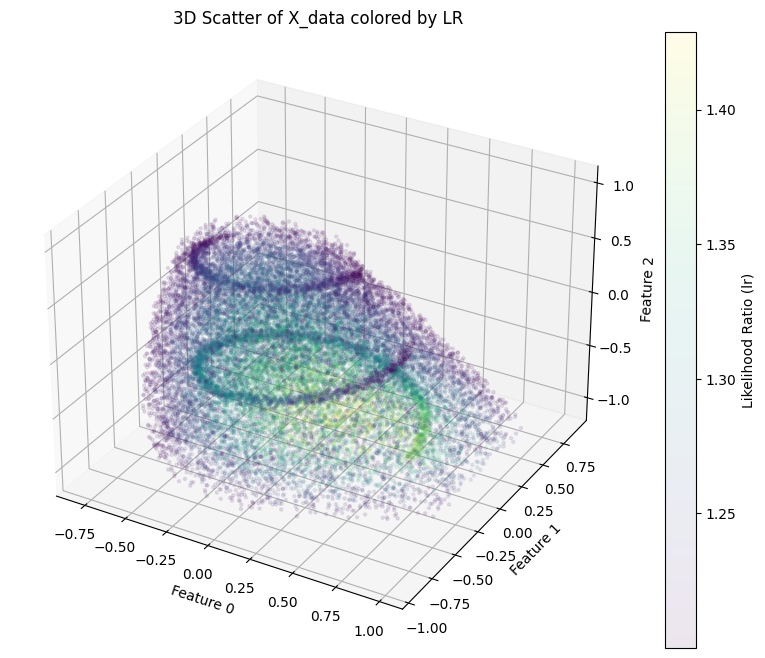

In [32]:
from mpl_toolkits.mplot3d import Axes3D

thresh = lr>1.2


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_data[:, 0][thresh], X_data[:, 1][thresh], X_data[:, 2][thresh], c=lr[thresh], cmap='viridis', s=5,alpha=0.1)
ax.set_xlabel('Feature 0')
ax.set_ylabel('Feature 1')
ax.set_zlabel('Feature 2')
plt.colorbar(sc, ax=ax, label='Likelihood Ratio (lr)')
plt.title('3D Scatter of X_data colored by LR')
plt.show()


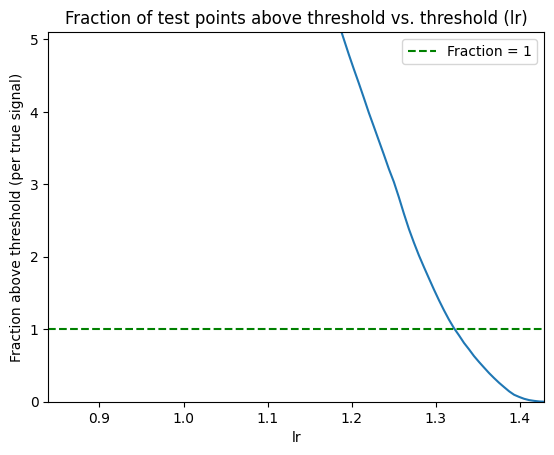

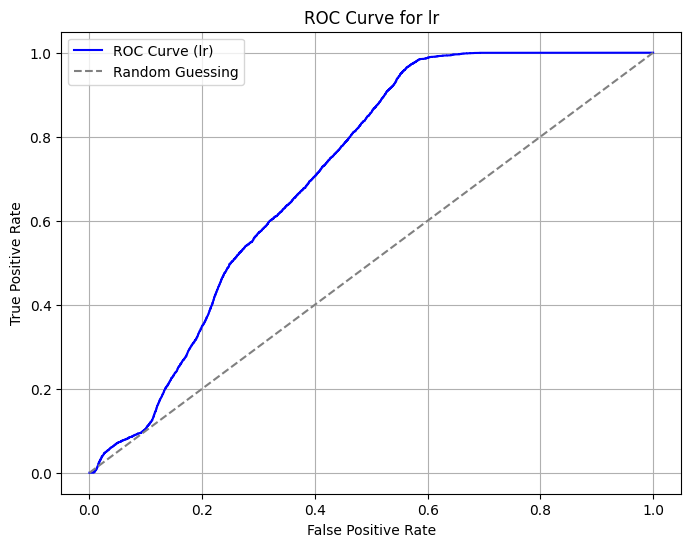

Total AUC (lr): 0.712168948


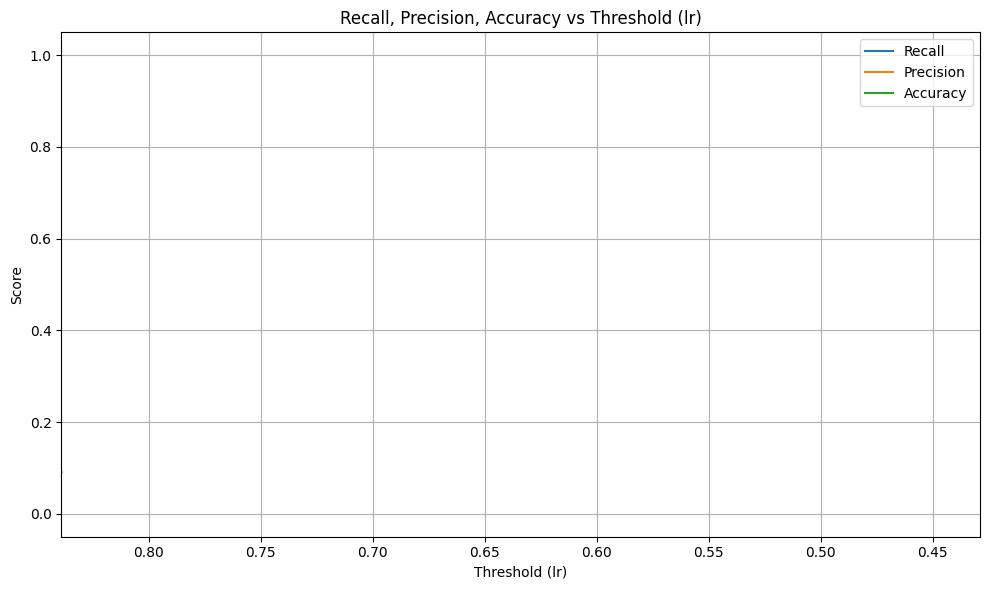

In [28]:
# Plot fraction above threshold vs. threshold using lr as metric
thresholds = np.linspace(np.min(lr), np.max(lr), 100)
fractions_lr = [np.sum(lr > t) / np.sum(signal_labels == 1) for t in thresholds]

plt.plot(thresholds, fractions_lr)
plt.xlabel('lr')
plt.ylabel('Fraction above threshold (per true signal)')
plt.title('Fraction of test points above threshold vs. threshold (lr)')
plt.axhline(1, color='green', linestyle='--', label='Fraction = 1')
plt.legend()
plt.ylim(0, 5.1)
plt.xlim(np.min(lr), np.max(lr))
plt.savefig("./MLP_comp_plots/lr_fraction_vs_threshold.png")
plt.show()

# ROC curve using lr as metric
from sklearn.metrics import roc_curve, roc_auc_score
fpr_lr, tpr_lr, thresholds_lr = roc_curve(signal_labels, lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label='ROC Curve (lr)', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for lr')
plt.legend()
plt.grid()
plt.savefig("./MLP_comp_plots/lr_roc_curve.png")
plt.show()
print("Total AUC (lr):", roc_auc_score(signal_labels, lr))

# Recall, Precision, Accuracy vs Threshold for lr
thresholds = np.linspace(np.min(lr), np.max(lr), 100)
recall_lr = []
precision_lr = []
accuracy_lr = []

for t in thresholds:
    preds = (lr > t).astype(int)
    tp = np.sum((preds == 1) & (signal_labels == 1))
    fp = np.sum((preds == 1) & (signal_labels == 0))
    tn = np.sum((preds == 0) & (signal_labels == 0))
    fn = np.sum((preds == 0) & (signal_labels == 1))
    recall_lr.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    precision_lr.append(tp / (tp + fp) if (tp + fp) > 0 else 0)
    accuracy_lr.append((tp + tn) / len(signal_labels))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, recall_lr, label='Recall')
plt.plot(thresholds, precision_lr, label='Precision')
plt.plot(thresholds, accuracy_lr, label='Accuracy')
plt.xlabel('Threshold (lr)')
plt.ylabel('Score')
plt.title('Recall, Precision, Accuracy vs Threshold (lr)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(np.min(lr), np.max(lr)-1)
plt.show()


# EagleEye vs KNN Classifier
## Dataset with extreme data imbalance

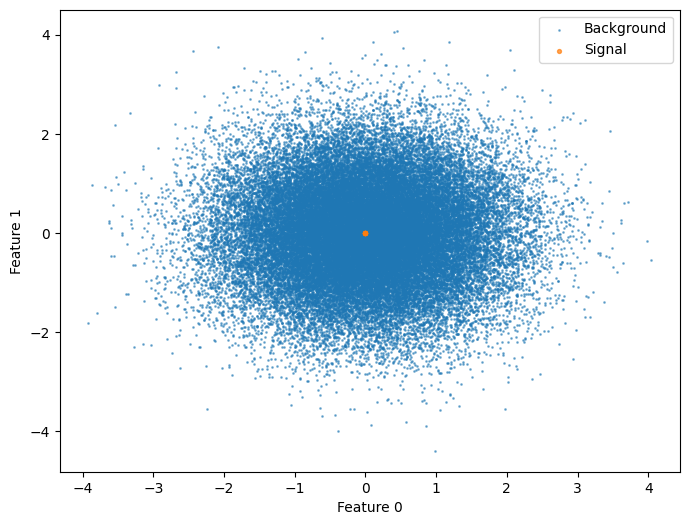

Number of background points: 50000
Number of signal points: 10
Number of reference points: 500000


In [30]:
d      = 5
n_bg   = 50000
n_sig  = 10         
sigma  = 0.0005

X_bg   = np.random.randn(n_bg, d)
X_sig  = np.random.randn(n_sig, d) * sigma   # much tighter

# labels: 0 = background, 1 = signal 
X_data        = np.vstack([X_bg, X_sig])
signal_labels = np.hstack([np.zeros(len(X_bg)), np.ones(n_sig)])
X_ref         = np.random.randn(n_bg*10, d)
y             = np.concatenate([np.zeros(len(X_ref)),np.ones(len(X_data))])

import matplotlib.pyplot as plt
# Plot the first two features, colored by label (background=0, signal=1)
plt.figure(figsize=(8, 6))
plt.scatter(X_data[signal_labels == 0, 0], X_data[signal_labels == 0, 1], s=1, alpha=0.5, label='Background')
plt.scatter(X_data[signal_labels == 1, 0], X_data[signal_labels == 1, 1], s=8, alpha=0.7, label='Signal')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.legend()
plt.savefig("/Users/andrescaffidi/Documents/Projects/EagleEye/examples/Basic_usage/MLP_comp_plots/haystack_data.png")
plt.show()
print(f"Number of background points: {n_bg}")
print(f"Number of signal points: {n_sig}")
print(f"Number of reference points: {len(X_ref)}")

In [31]:
len(X_data) / (len(X_ref) + len(X_data)) 

0.09092561953419029

In [32]:
p_ext = 1e-5
eagleeye_test_result = eagleeye_test(X_ref, X_data,do_IDE=True,p_ext=p_ext)


-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
KNN completed: 1.82 %
KNN completed: 3.64 %
KNN completed: 5.45 %
KNN completed: 7.27 %
KNN completed: 9.09 %
KNN completed: 10.91 %
KNN completed: 12.73 %
KNN completed: 14.55 %
KNN completed: 16.36 %
KNN completed: 18.18 %
KNN completed: 20.00 %
KNN completed: 21.82 %
KNN completed: 23.64 %
KNN completed: 25.45 %
KNN completed: 27.27 %
KNN completed: 29.09 %
KNN completed: 30.91 %
KNN completed: 32.73 %
KNN completed: 34.54 %
KNN completed: 36.36 %
KNN completed: 38.18 %
KNN completed: 40.00 %
KNN completed: 41.82 %
KNN completed: 43.64 %
KNN completed: 45.45 %
KNN completed: 47.27 %
KNN completed: 49.09 %
KNN completed: 50.91 %
KNN completed: 52.73 %
KNN completed: 54.54 %
KNN completed: 56.36 %
KNN completed: 58.18 %
KNN completed: 60.00 %
KNN completed: 61.82 %
KNN completed: 63.64 %
K

<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Pruning via iterative density equalization (IDE)
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

Elapsed time: 51.50491690635681 seconds


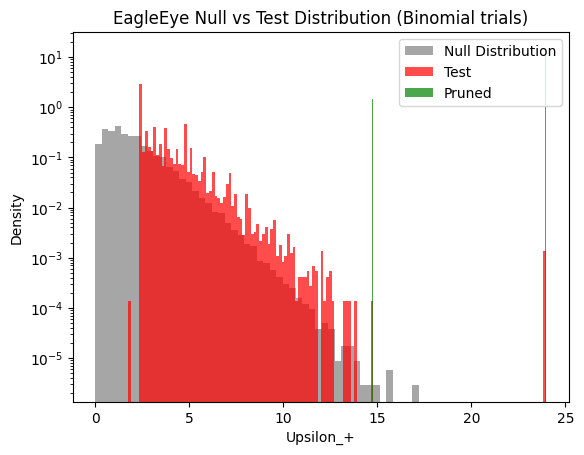

In [33]:
h = plt.hist(list(eagleeye_test_result[0].values())[0], bins=50, alpha=0.7, label='Null Distribution', color='grey', density=True)
h = plt.hist(eagleeye_test_result[1]['Upsilon_i_Y'], bins=150, alpha=0.7, label='Test', color='red', density=True)
h = plt.hist(eagleeye_test_result[1]['Upsilon_i_Y'][eagleeye_test_result[1]['Y_Pruned'][p_ext]], bins=150, alpha=0.7, label='Pruned', color='green', density=True)

plt.yscale('log')
plt.xlabel('Upsilon_+')
plt.ylabel('Density')
plt.title('EagleEye Null vs Test Distribution (Binomial trials)')
plt.legend()
plt.show()

In [34]:
eagleeye_test_result[1]['Y_Pruned'][p_ext], np.where(signal_labels==1)[0]

(array([50000, 50001, 50002, 50003, 50004, 50005, 50006, 50007, 50008,
        50009, 48422]),
 array([50000, 50001, 50002, 50003, 50004, 50005, 50006, 50007, 50008,
        50009]))

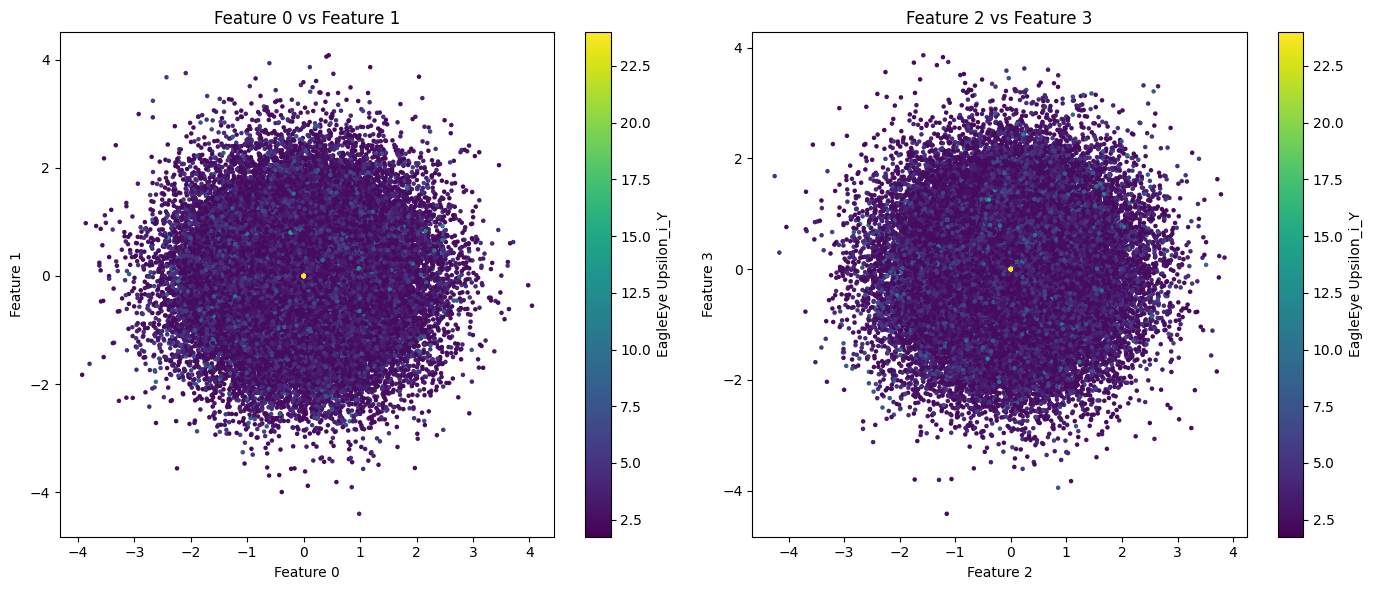

<Figure size 640x480 with 0 Axes>

In [35]:
# Scatter plots for first two features and last two features, colored by EagleEye statistic
upsilon = eagleeye_test_result[1]['Upsilon_i_Y']
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sc0 = axes[0].scatter(X_data[:, 0], X_data[:, 1], c=upsilon, cmap='viridis', s=5)
axes[0].set_xlabel('Feature 0')
axes[0].set_ylabel('Feature 1')
axes[0].set_title('Feature 0 vs Feature 1')
plt.colorbar(sc0, ax=axes[0], label='EagleEye Upsilon_i_Y')

sc1 = axes[1].scatter(X_data[:, 2], X_data[:, 3], c=upsilon, cmap='viridis', s=5)
axes[1].set_xlabel('Feature 2')
axes[1].set_ylabel('Feature 3')
axes[1].set_title('Feature 2 vs Feature 3')
plt.colorbar(sc1, ax=axes[1], label='EagleEye Upsilon_i_Y')
plt.tight_layout()
plt.savefig("./MLP_comp_plots/eagleeye_scatter_01_23.png")
plt.show()


plt.tight_layout()
plt.show()


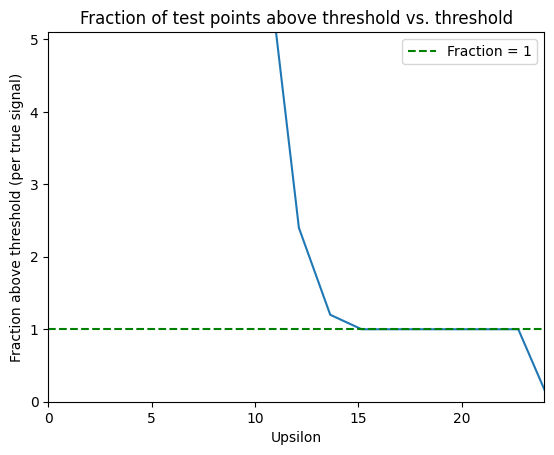

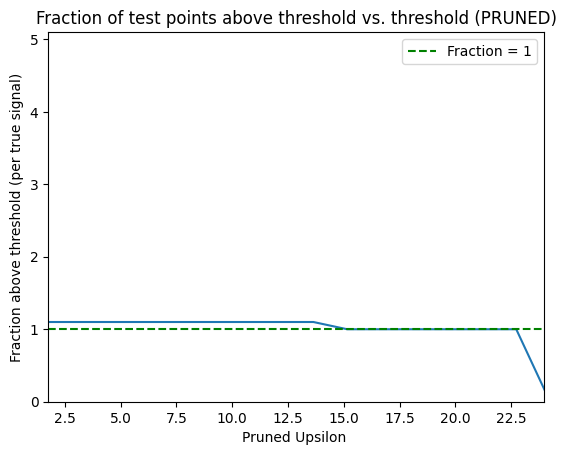

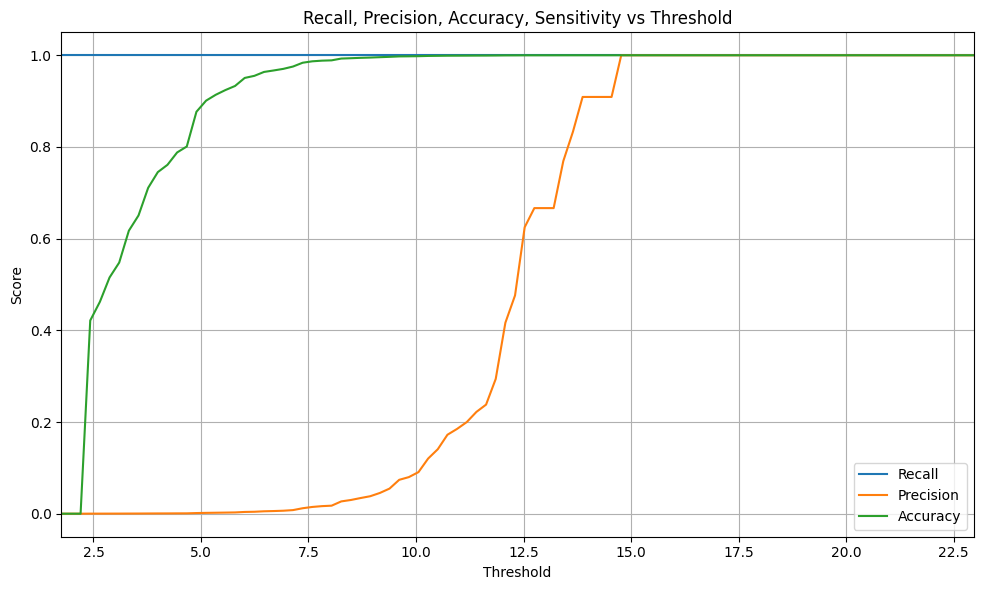

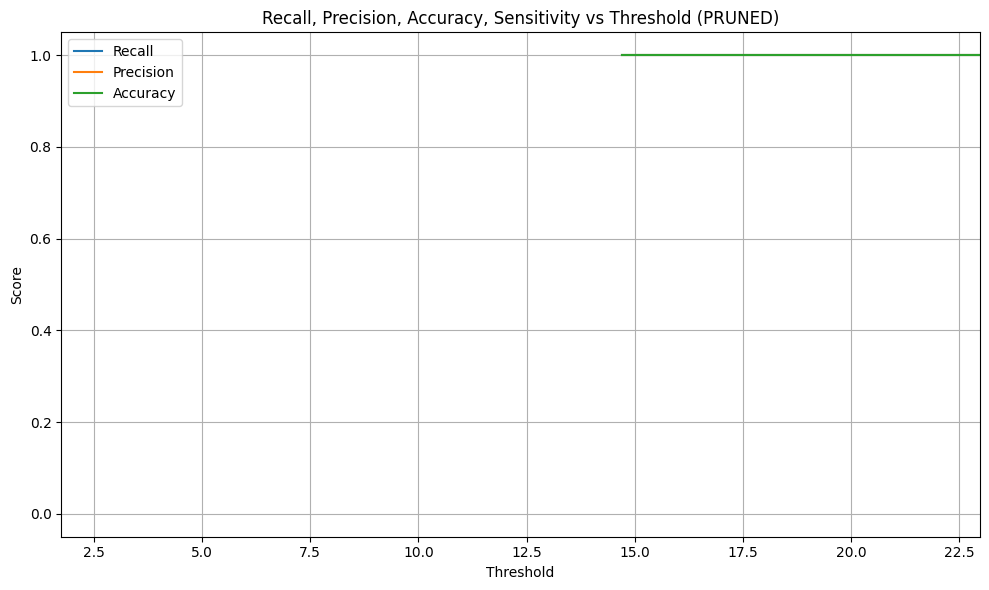

In [37]:

thresholds = np.linspace(0, 150, 100)
fractions = [np.sum(eagleeye_test_result[1]['Upsilon_i_Y']  > t) / np.sum(signal_labels==1) for t in thresholds]

plt.plot(thresholds, fractions)
plt.xlabel('Upsilon')
plt.ylabel('Fraction above threshold (per true signal)')
plt.title('Fraction of test points above threshold vs. threshold')
plt.axhline(1, color='green', linestyle='--', label='Fraction = 1')
plt.legend()
plt.ylim(0, 5.1)
plt.xlim(0, max(eagleeye_test_result[1]['Upsilon_i_Y']) )
plt.savefig("./MLP_comp_plots/eagleeye_fraction_vs_threshold.png")
plt.show()

thresholds = np.linspace(0, 150, 100)
fractions_pruned = [np.sum(eagleeye_test_result[1]['Upsilon_i_Y'][eagleeye_test_result[1]['Y_Pruned'][p_ext]]  > t) / np.sum(signal_labels==1) for t in thresholds]

plt.plot(thresholds, fractions_pruned)
plt.xlabel('Pruned Upsilon ')
plt.ylabel('Fraction above threshold (per true signal)')
plt.title('Fraction of test points above threshold vs. threshold (PRUNED)')
plt.axhline(1, color='green', linestyle='--', label='Fraction = 1')
plt.legend()
plt.ylim(0, 5.1)
plt.xlim(min(eagleeye_test_result[1]['Upsilon_i_Y']), max(eagleeye_test_result[1]['Upsilon_i_Y']))
plt.savefig("./MLP_comp_plots/eagleeye_fraction_vs_threshold_pruned.png")
plt.show()

thresholds = np.linspace(min(eagleeye_test_result[1]['Upsilon_i_Y']), max(eagleeye_test_result[1]['Upsilon_i_Y']), 100)
recall = []
precision = []
accuracy = []
sensitivity = []

for t in thresholds:
    preds = (eagleeye_test_result[1]['Upsilon_i_Y'] > t).astype(int)
    tp = np.sum((preds == 1) & (signal_labels == 1))
    fp = np.sum((preds == 1) & (signal_labels == 0))
    tn = np.sum((preds == 0) & (signal_labels == 0))
    fn = np.sum((preds == 0) & (signal_labels == 1))
    recall.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    precision.append(tp / (tp + fp) if (tp + fp) > 0 else 0)
    accuracy.append((tp + tn) / len(signal_labels))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, recall, label='Recall')
plt.plot(thresholds, precision, label='Precision')
plt.plot(thresholds, accuracy, label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Recall, Precision, Accuracy, Sensitivity vs Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(min(eagleeye_test_result[1]['Upsilon_i_Y']), max(eagleeye_test_result[1]['Upsilon_i_Y'])-1)
plt.show()


thresholds = np.linspace(min(eagleeye_test_result[1]['Upsilon_i_Y'][eagleeye_test_result[1]['Y_Pruned'][p_ext]]), max(eagleeye_test_result[1]['Upsilon_i_Y'][eagleeye_test_result[1]['Y_Pruned'][p_ext]]), 100)
recall = []
precision = []
accuracy = []
sensitivity = []

for t in thresholds:
    preds = (eagleeye_test_result[1]['Upsilon_i_Y'][eagleeye_test_result[1]['Y_Pruned'][p_ext]] > t).astype(int)
    tp = np.sum((preds == 1) & (signal_labels[eagleeye_test_result[1]['Y_Pruned'][p_ext]] == 1))
    fp = np.sum((preds == 1) & (signal_labels[eagleeye_test_result[1]['Y_Pruned'][p_ext]] == 0))
    tn = np.sum((preds == 0) & (signal_labels[eagleeye_test_result[1]['Y_Pruned'][p_ext]] == 0))
    fn = np.sum((preds == 0) & (signal_labels[eagleeye_test_result[1]['Y_Pruned'][p_ext]] == 1))
    recall.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    precision.append(tp / (tp + fp) if (tp + fp) > 0 else 0)
    accuracy.append((tp + tn) / len(signal_labels[eagleeye_test_result[1]['Y_Pruned'][p_ext]]))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, recall, label='Recall')
plt.plot(thresholds, precision, label='Precision')
plt.plot(thresholds, accuracy, label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Recall, Precision, Accuracy, Sensitivity vs Threshold (PRUNED)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(min(eagleeye_test_result[1]['Upsilon_i_Y']), max(eagleeye_test_result[1]['Upsilon_i_Y'])-1)
plt.show()

## kNN with simple voting rule

In [141]:
# ---------- k-NN classifier ----------
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=200,metric='euclidean')
clf.fit(np.concatenate([X_ref, X_data]), y)                     # background vs data
def extract_lr_from_knn(knn_model, x_data, eps=1e-12):
    """
    Compute likelihood ratio from KNN classifier output for input data.

    Parameters
    ----------
    knn_model : trained KNeighborsClassifier with predict_proba method
    x_data    : array-like, shape (n_samples, n_features)
    eps       : float, small value to avoid division by zero

    Returns
    -------
    lr : ndarray, likelihood ratio for each sample
    """
    prob = knn_model.predict_proba(x_data)[:, 1]
    return prob / (1 - prob + eps)

# Example usage:
lr_knn = extract_lr_from_knn(clf, X_data)


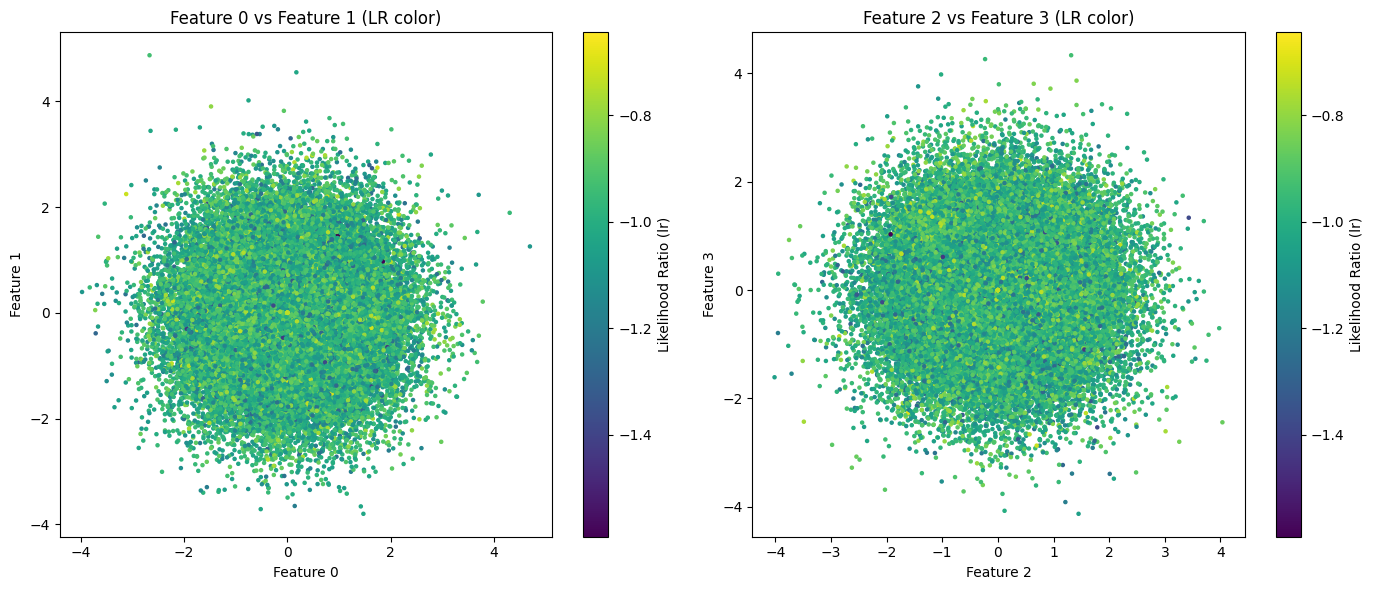

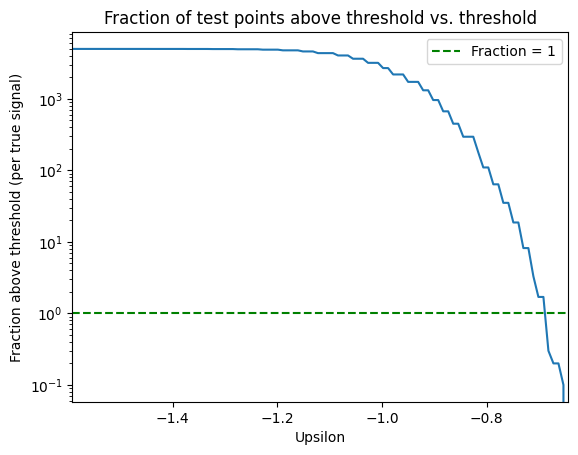

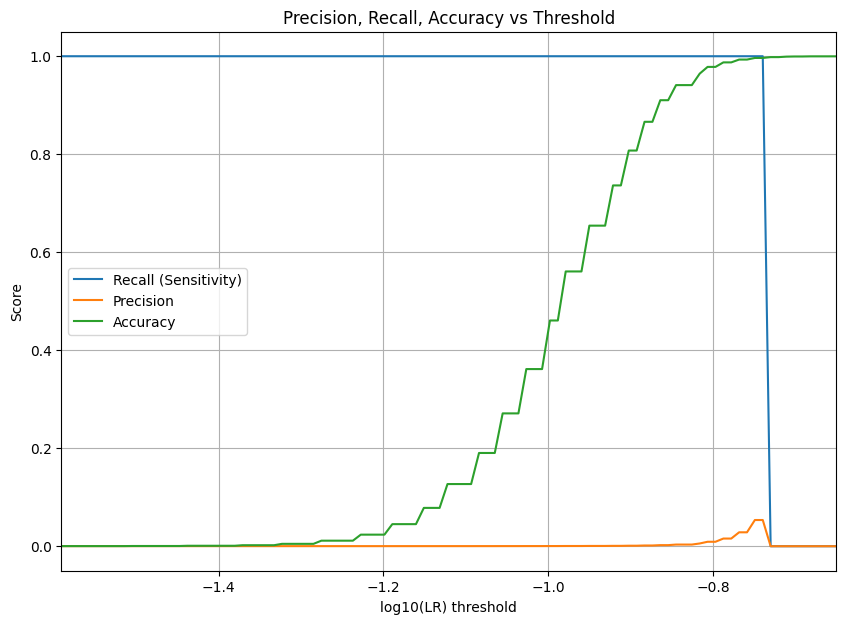

In [180]:
import matplotlib.pyplot as plt

# Plot feature pairs (0,1), (2,3), (4,5), (6,7) colored by lr
feature_pairs = [(0, 1), (2, 3)]
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for ax, (i, j) in zip(axes.ravel(), feature_pairs):
    sc = ax.scatter(X_data[:, i], X_data[:, j], c=np.log10(lr_knn), cmap='viridis', s=5)
    ax.set_xlabel(f'Feature {i}')
    ax.set_ylabel(f'Feature {j}')
    ax.set_title(f'Feature {i} vs Feature {j} (LR color)')
    plt.colorbar(sc, ax=ax, label='Likelihood Ratio (lr)')

plt.tight_layout()
plt.show()
thresholds = np.linspace(np.min(np.log10(lr_knn)), np.max(np.log10(lr_knn)), 100)
fractions = [np.sum(np.log10(lr_knn) > t) / np.sum(signal_labels) for t in thresholds]

plt.plot(thresholds, fractions)
plt.xlabel('Upsilon')
plt.ylabel('Fraction above threshold (per true signal)')
plt.title('Fraction of test points above threshold vs. threshold')
plt.axhline(1, color='green', linestyle='--', label='Fraction = 1')
plt.legend()
plt.yscale('log')
# plt.ylim(0, 5.1)
plt.xlim(min(np.log10(lr_knn)), max(np.log10(lr_knn)) )
plt.show()

# # ROC curve 

# from sklearn.metrics import roc_curve, roc_auc_score
# fpr, tpr, thresholds = roc_curve(signal_labels, np.log10(lr_knn))
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, label='ROC Curve', color='blue')
# plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for kNN Two-Sample Test')
# plt.legend()
# plt.grid()
# plt.show()
# print("Total AUC:", roc_auc_score(signal_labels, np.log10(lr_knn)))


thresholds = np.linspace(np.min(np.log10(lr_knn)), np.max(np.log10(lr_knn)), 100)
precision = []
recall = []
accuracy = []
sensitivity = []

for t in thresholds:
    preds = (np.log10(lr_knn) >= t).astype(int)
    tp = np.sum((preds == 1) & (signal_labels == 1))
    fp = np.sum((preds == 1) & (signal_labels == 0))
    tn = np.sum((preds == 0) & (signal_labels == 0))
    fn = np.sum((preds == 0) & (signal_labels == 1))
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0
    rec = tp / (tp + fn) if (tp + fn) > 0 else 0
    acc = (tp + tn) / (tp + tn + fp + fn)
    precision.append(prec)
    recall.append(rec)
    accuracy.append(acc)
    sensitivity.append(sens)

plt.figure(figsize=(10, 7))
plt.plot(thresholds, recall, label='Recall (Sensitivity)')
plt.plot(thresholds, precision, label='Precision')
plt.plot(thresholds, accuracy, label='Accuracy')
plt.xlabel('log10(LR) threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, Accuracy vs Threshold')
plt.legend()
plt.grid(True)
plt.xlim(min(np.log10(lr_knn)), max(np.log10(lr_knn))+0.01*np.max(np.log10(lr_knn)))
plt.show()
